# Time Series Analysis

**У цьому розіділі дізнаємось**

- Що таке часовий ряд
- Компоненти часового ряду
- Поняття автокореляції, часткової автокореляції, стаціонарного ряду
- Бібліотека Darts
- Диференціювання і логарифмування ряду
- Методи для прогнозування часових рядів
 - Exponensial Smoothing, Theta
 - ARIMA, SARIMA, SARIMAX
 - Facebook Prophet
 - RNN, LSTM
 - Transformers
 - XGBoost для часових рядів
- Backtesting
- Residual analysis


**Погнали!**

# Визначення часового ряду і де використовується Time Series Analysis

**Часовий ряд** – це послідовність значень, спостережених через рівні інтервали часу.
Приклади часових рядів: кількість продажів за місяць, погодні умови, рівень безробіття.
Аналіз часових рядів є важливою складовою в різних сферах.

## Use-кейси time series analysis:

- **Бізнес-аналітика**: прогнозування продажів, відвідуваності веб-сайтів, активності користувачів.
- **Маркетинг**: прогнозування попиту на продукти та послуги, планування рекламних кампаній.
- **Фінансовий сектор**: прогнозування цін на акції, аналіз ринкових тенденцій.
- **Логістика та управління запасами**: прогнозування попиту на товари, планування поставок.
- **Соціальні науки**: аналіз тенденцій у соціальних мережах, прогнозування чисельності населення.


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as pxperiod=

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)
display(data.head())

data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
fig = px.line(data, y='Passengers')

fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='Airline Passengers', width=650, title_x=0.5, height=400)


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


## Особливості роботи з time series

#### Інформаційна насиченість

Часові ряди містять в собі багато інформації. Оскільки це дуже поширений тип даних, дослідники вивели наступні компоненти будь-якого часового ряду:
- **Тренд**: Довгострокові зміни у часі.
- **Сезонність**: Повторювані патерни у певні інтервали часу.
- **Циклічність**: Довгострокові коливання, пов'язані з економічними циклами або іншими подіями.
- **Залишки**: Непередбачувані флуктуації.

#### Прогнозування на основі історичних даних

Однією з основних задач при роботі з часовими рядами є прогнозування майбутніх значень на основі історичних даних. Це можливо завдяки виявленню та аналізу внутрішніх структур і патернів у даних.

- **Просторово-часова залежність**: Значення у часових рядах залежать від попередніх значень. Це відрізняє їх від багатьох інших типів даних. Відповідно коли ми будуємо модель, ми завжди навчаємось на старіших істрично даних, а валідуємось на новіших. Процедура крос валідації працює за схожим принципом.
- **Автокореляція**: Часові ряди часто демонструють автокореляцію, що означає, що значення у ряду корелюють з попередніми значеннями. Наприклад, погода сьогодні часто схожа на погоду вчора і цей патерн повторюєть в історії. Нам корисно вимірювати міру автокореляції аби використати її в моделюванні.

## Основні компоненти часових рядів

### Тренд
Тренд відображає довгострокову зміну **середнього** рівня часового ряду. Він показує, як змінюється значення ряду в довгостроковій перспективі – зростає, зменшується або залишається стабільним.

- **Висхідний тренд**: свідчить про загальне збільшення значень часового ряду з часом.
- **Нисхідний тренд**: свідчить про загальне зменшення значень часового ряду з часом.
- **Стабільний тренд**: значення часового ряду залишаються на приблизно одному рівні протягом тривалого періоду.

#### Сезонність
Сезонність представляє повторювані патерни або коливання в даних, які відбуваються з регулярною періодичністю, наприклад, щороку, щомісяця або щотижня.

- **Приклад сезонності**: збільшення продажів льоду/пива/камбучі влітку та зменшення взимку.

Сезонність може бути адитивною (додається до тренду) або мультиплікативною (множиться на тренд).

#### Циклічність
Циклічність відображає **довгострокові** коливання в даних, які **не є регулярними**, на відміну від сезонності. Вони можуть тривати кілька років і зазвичай пов'язані з економічними циклами, політичними подіями тощо.

- **Приклад циклічності**: економічні цикли бумів і спадів.

Циклічність складна для виявлення, тому базові бібліотеки її не витягують з ряда. Маємо це робити вручну.

#### Залишки (резідуали)
Залишки – це випадкова складова, яка не може бути пояснена трендом, сезонністю або циклічністю. Вони представляють випадковий шум або непередбачувані флуктуації (коливань) в даних.

Виявлення цих компонент з часового ряду називається декомпозицією.


## Адитивна та Мультиплікативна моделі в аналізі часових рядів

Для моделювання компонент часового ряду - тренду, сезонності, циклічності і залишків використовуються дві основні моделі: адитивна та мультиплікативна. Давайте розглянемо кожну з них детальніше.

![](https://kourentzes.com/predictioning/wp-content/uploads/2014/11/mseas.fig1_.png)

#### Адитивна модель

**Адитивна модель** припускає, що компоненти часових рядів (тренд, сезонність, циклічність і залишки) додаються один до одного. Ця модель підходить для даних, де амплітуда сезонних коливань залишається постійною незалежно від рівня тренду.

**Формула адитивної моделі**:
$$ Y_t = T_t + S_t + C_t + E_t $$

де:
- $ Y_t $ — значення часового ряду в момент часу $ t $.
- $ T_t $ — трендова складова (довгострокова тенденція).
- $ S_t $ — сезонна складова (регулярні повторювані патерни).
- $ C_t $ — циклічна складова (довгострокові нерегулярні коливання).
- $ E_t $ — залишкова складова (випадковий шум).

**Приклад**:
Уявіть, що ви аналізуєте місячні продажі кави. У вас є загальний тренд зростання продажів, сезонні коливання з піками взимку та літом, циклічні коливання, пов'язані з економічними циклами, і випадкові коливання, такі як несподівані події. В адитивній моделі ці компоненти додаються один до одного.

**Як компоненти виглядають на візуалізації**:
- Тренд — плавна лінія, що показує загальну тенденцію.
- Сезонність — хвиляста лінія, що додається до тренду.
- Циклічність — довгострокові коливання навколо тренду.
- Залишки — випадкові коливання навколо тренду та сезонності.

#### Мультиплікативна модель

**Мультиплікативна модель** припускає, що компоненти часових рядів множаться один на одного. Ця модель підходить для даних, де **амплітуда сезонних коливань змінюється пропорційно до рівня тренду.**

**Формула мультиплікативної моделі**:
$$ Y_t = T_t \times S_t \times C_t \times E_t $$

де:
- $ Y_t $ — значення часового ряду в момент часу $ t $.
- $ T_t $ — трендова складова.
- $ S_t $ — сезонна складова.
- $ C_t $ — циклічна складова.
- $ E_t $ — залишкова складова.

#### Приклад
Аби відчути, як це працює, давайте зробимо декомпозицію часового ряду вручну. Спочатку адитивна модель:


In [ ]:
df_additive = data.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 13
df_additive["trend"] = df_additive["Passengers"].rolling(window=13, center=True).mean()

# віднімаємо тренд з даних
df_additive["detrended"] = df_additive["Passengers"] - df_additive["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_additive["month"] = df_additive.index.month
df_additive["seasonality"] = df_additive.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_additive["resid"] = df_additive["detrended"] - df_additive["seasonality"]

# що у нас вийшло в результаті
df_additive.head(15)

,Passengers,trend,detrended,month,seasonality,resid
Month,,,,,,
1949-01-01,112,NaN,NaN,1,-30.825175,NaN
1949-02-01,118,NaN,NaN,2,-42.027972,NaN
1949-03-01,132,NaN,NaN,3,-4.139860,NaN
1949-04-01,129,NaN,NaN,4,-6.944056,NaN
1949-05-01,121,NaN,NaN,5,-0.699301,NaN
1949-06-01,135,NaN,NaN,6,37.146853,NaN
1949-07-01,148,125.769231,22.230769,7,64.923077,-42.692308
1949-08-01,148,126.846154,21.153846,8,64.580420,-43.426573
1949-09-01,136,128.615385,7.384615,9,15.636364,-8.251748


<Axes: xlabel='Month'>

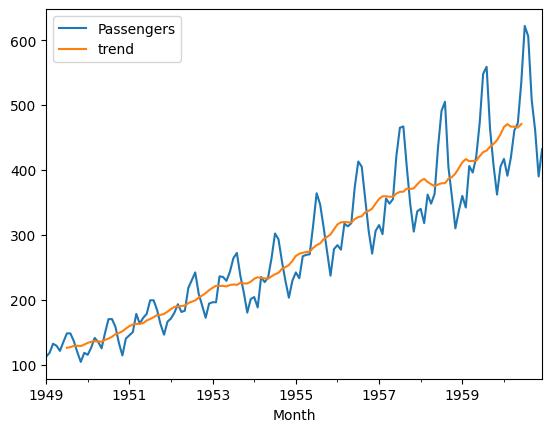

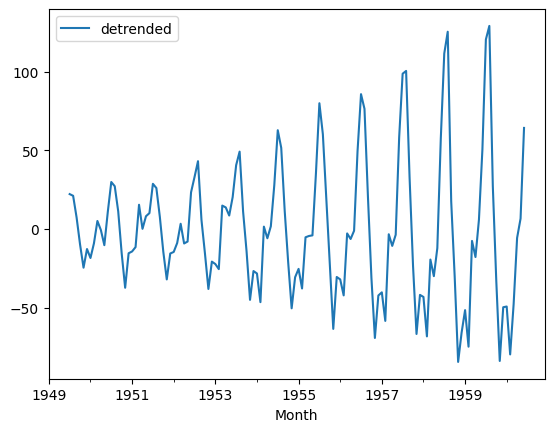

In [ ]:
df_additive["trend_26"] = df_additive["Passengers"].rolling(window=26, center=True).mean()
df_additive[["Passengers", "trend"]].plot()
df_additive[["detrended"]].plot()

Візуалізація ковзного вікна

![](https://docs.wavefront.com/images/5sec_moving_window.png)

Приклад порівняння оригінального часового ряду і його середнього з вікном 7 (7 days rolling mean) - ковзне середнє завжди згладжує дані, але важливо аби воно було з тою ж сезонністю, що і дані:

![](https://i0.wp.com/statisticsbyjim.com/wp-content/uploads/2020/07/FLMovingAverageCOVIDDeaths.png?fit=579%2C398&ssl=1)

In [ ]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4, 5, 6]})
df['rolling'] = df.rolling(3).sum()
df


,B,rolling
0,0,NaN
1,1,NaN
2,2,3.0
3,3,6.0
4,4,9.0
5,5,12.0
6,6,15.0


Візуалізуємо наш ряд після декомпозиції:

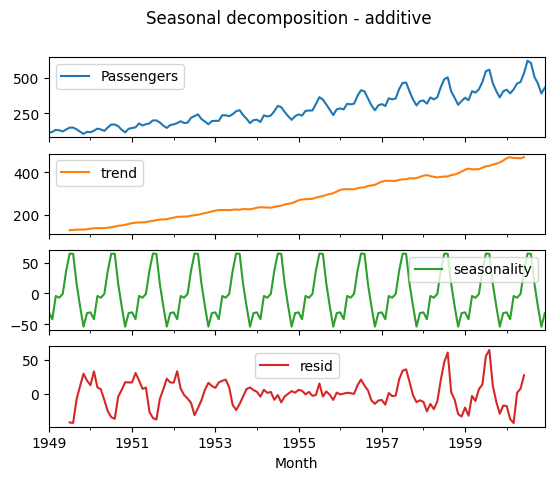

In [ ]:
(
    df_additive
    .loc[:, ["Passengers", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

Мультиплікативна модель:

In [ ]:
df_mult = data.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 13
df_mult["trend"] = df_mult["Passengers"].rolling(window=13, center=True).mean()

# віднімаємо тренд з даних
df_mult["detrended"] = df_mult["Passengers"] / df_mult["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_mult["month"] = df_mult.index.month
df_mult["seasonality"] = df_mult.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_mult["resid"] = df_mult["detrended"] / df_mult["seasonality"]

# що у нас вийшло в результаті
df_mult.head(15)

,Passengers,trend,detrended,month,seasonality,resid
Month,,,,,,
1949-01-01,112,NaN,NaN,1,0.892578,NaN
1949-02-01,118,NaN,NaN,2,0.867495,NaN
1949-03-01,132,NaN,NaN,3,1.001503,NaN
1949-04-01,129,NaN,NaN,4,0.980513,NaN
1949-05-01,121,NaN,NaN,5,0.995268,NaN
1949-06-01,135,NaN,NaN,6,1.119924,NaN
1949-07-01,148,125.769231,1.176758,7,1.232875,0.954483
1949-08-01,148,126.846154,1.166768,8,1.228056,0.950093
1949-09-01,136,128.615385,1.057416,9,1.056833,1.000552


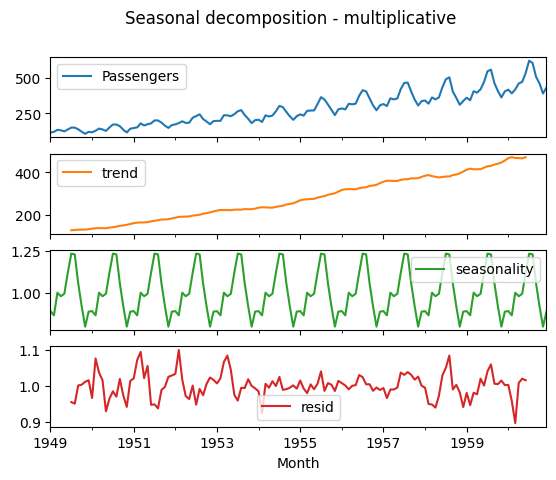

In [ ]:
(
    df_mult
    .loc[:, ["Passengers", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - multiplicative")
);

Звісно, в Python вже існують зручні методи аби робити декомпозицію.

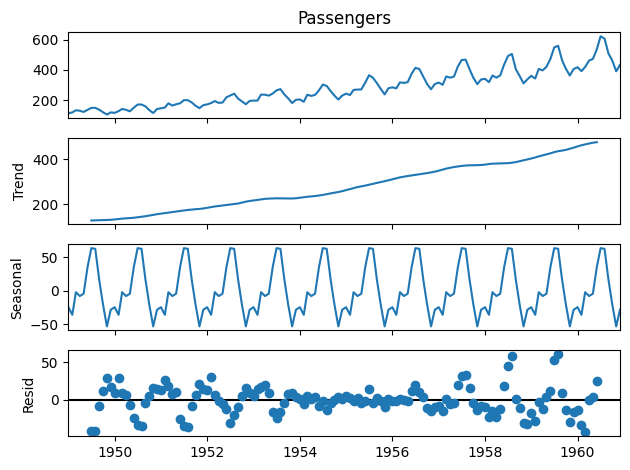

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(data['Passengers'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

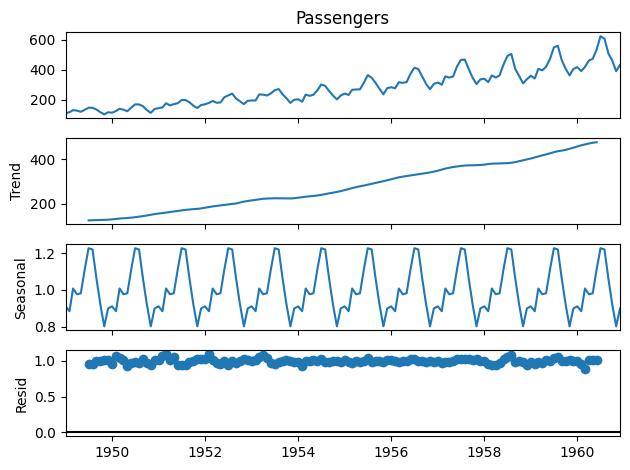

In [ ]:
# Візуалізація мультиплікативної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(data['Passengers'],
                                              model='multiplicative')
decomposition_plot_multi.plot()
plt.show()

**Як інтерпретувати чи декомпозиція хороша і пасує ряду?**

Ми хочемо аби ресидуали в ідеалі мали маленьке стандартне відхилення і були навколо нуля. Враховуємо при цьому, що в адитивній моделі додаються значення, а в мультиплікативній - множаться, тож аналізуємо залишки памʼятаючи про це. Якщо є якийсь паттерн в ресидуалах - це неок, але маємо розуміти, що в реальних проєктах ідеальної теоретичної картинки не буває :)

**Передбачення для історичних даних тільки на декомпозиції**

Зробивши декомпозицію ми вже можемо обчислити передбачення ряду на історичних даних.



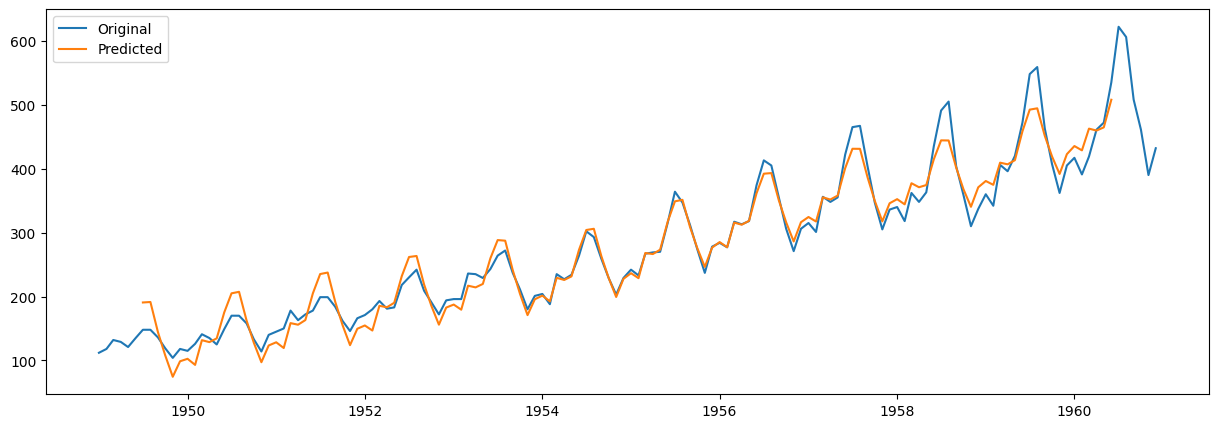

In [ ]:
# Обчислюємо передбачення
df_predicted_from_additional = df_additive.copy(deep=True)
df_predicted_from_additional["predicted"] = df_predicted_from_additional["trend"] + df_predicted_from_additional["seasonality"]

# Візуалізуємо
plt.figure(figsize=(15, 5))
plt.plot(df_predicted_from_additional["Passengers"])
plt.plot(df_predicted_from_additional["predicted"])
plt.legend(["Original", "Predicted"])
plt.show()

**А як же прогнозувати для майбутніх періодів?**

Подумайте, як би ви прогнозували, а ми до цього дійдемо після того, як познайомимось ще з деякими поняттями.

## Обчислення помилки прогнозування часового ряду

Найбільш поширені метрики для виміру точності прогнозування моделлю часового ряду включають MAE, MSE, RMSE, MAPE.

### Коли використовувати різні метрики помилки прогнозування

При оцінці точності моделей прогнозування часових рядів важливо вибрати відповідні метрики помилки. Кожна метрика має свої особливості та використовується в залежності від конкретної ситуації.

#### 1. Mean Absolute Error (MAE) - Середня Абсолютна Похибка

**Формула**:
$$ MAE = \frac{1}{n} \sum_{t=1}^{n} |Y_t - \hat{Y}_t| $$

**Коли використовувати**:
- **Простота інтерпретації**: MAE легко інтерпретувати, оскільки вона представляє середню величину помилки в тих самих одиницях, що й вихідні дані.
- **Рівномірна важливість помилок**: MAE підходить, коли всі помилки мають однакову вагу, тобто великі помилки не караються більше, ніж малі.
- **Робота з викидами**: MAE менш чутлива до викидів у порівнянні з MSE та RMSE, оскільки вона не підносить помилки до квадрата.

**Приклад**: Якщо ви прогнозуєте температуру або рівень продажів, де однакова вага помилок важлива, MAE буде хорошим вибором.

#### 2. Mean Squared Error (MSE) - Середньоквадратична Похибка

**Формула**:
$$ MSE = \frac{1}{n} \sum_{t=1}^{n} (Y_t - \hat{Y}_t)^2 $$

**Коли використовувати**:
- **Акцент на великі помилки**: MSE карає великі помилки більше, ніж малі, оскільки підносить помилки до квадрата. Це корисно, якщо важливо мінімізувати великі помилки.
- **Теоретична база**: MSE часто використовується в теоретичних дослідженнях та машинному навчанні через її властивості в статистиці та оптимізації.
- **Континуум значень**: Підходить для даних, де є широкий діапазон значень і великі помилки особливо небажані.

**Приклад**: Якщо ви прогнозуєте ціни на акції, де великі помилки можуть мати серйозні фінансові наслідки, MSE може бути корисною метрикою.

#### 3. Root Mean Squared Error (RMSE) - Корінь Середньоквадратичної Похибки

**Формула**:
$$ RMSE = \sqrt{MSE} $$

**Коли використовувати**:
- **Інтерпретація в одиницях даних**: RMSE надає результат в тих самих одиницях, що й вихідні дані, що робить її легко інтерпретованою.
- **Сильний акцент на великі помилки**: Як і MSE, RMSE чутлива до великих помилок, але надає результати у вихідних одиницях.
- **Порівняння моделей**: RMSE часто використовується для порівняння якості різних моделей, оскільки дає зрозуміле уявлення про середню похибку.

**Приклад**: Якщо ви прогнозуєте рівень води у річці, де великі помилки можуть призвести до неправильних рішень щодо управління водними ресурсами, RMSE буде корисною метрикою.

#### 4. Mean Absolute Percentage Error (MAPE) - Середня Абсолютна Відсоткова Похибка

**Формула**:
$$ MAPE = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{Y_t - \hat{Y}_t}{Y_t} \right| \times 100\% $$

**Коли використовувати**:
- **Інтерпретація у відсотках**: MAPE дає результат у відсотках, що робить її легко зрозумілою для бізнесу та управлінських рішень.
- **Порівняння різних часових рядів**: Підходить для порівняння точності прогнозів на різних часових рядах з різними масштабами.
- **Чутливість до нульових значень**: MAPE може бути проблематичною, якщо дані містять нульові або дуже малі значення, оскільки це може призвести до дуже великих значень MAPE.

**Приклад**: Якщо ви прогнозуєте відсоткові зміни, такі як ріст або зниження продажів, MAPE буде доречною метрикою, оскільки вона показує середню відсоткову похибку прогнозу.



In [ ]:
# df_predicted_from_additional['predicted']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

na_predictions = df_predicted_from_additional[~df_predicted_from_additional['predicted'].isna()].index
target = data['Passengers'][na_predictions]
prediction = df_predicted_from_additional['predicted'][na_predictions]

# Обчислення MAE
mae = mean_absolute_error(target, prediction)
print(f'Mean Absolute Error (MAE): {mae}')

# Обчислення MSE
mse = mean_squared_error(target, prediction)
print(f'Mean Squared Error (MSE): {mse}')

# Обчислення RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Обчислення MAPE
mape = np.mean(np.abs((target - prediction) / target)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 15.16380589107862
Mean Squared Error (MSE): 407.67912856374403
Root Mean Squared Error (RMSE): 20.191065562860818
Mean Absolute Percentage Error (MAPE): 6.366958778283993%


## Автокореляція

**Автокореляція** (або автоковаріація) — це статистична міра, яка визначає ступінь подібності значень часового ряду з його власними минулими значеннями через різні лаги (інтервали часу). Вона допомагає виявити періодичні патерни, тренди та залежності у часових рядах, що є важливим для аналізу та прогнозування.

Основними поняттями для розуміння автокореляції є:

- **Лаг (lag)**: інтервал часу між порівнюваними значеннями в часовому ряду. Наприклад, автокореляція з лагом 1 порівнює значення в момент часу $t$ з його значенням у момент часу $t-1$.
- **Автокореляційна функція (ACF)**: показує автокореляцію для різних лагів. ACF дозволяє виявити, як змінюється автокореляція зі збільшенням лагу.

#### Формула автокореляції

Автокореляція для лагу $k$ обчислюється як кореляція між значеннями часового ряду, зсунутими на $k$ періодів:

$$ \rho_k = \frac{\sum_{t=k+1}^{n} (Y_t - \bar{Y})(Y_{t-k} - \bar{Y})}{\sum_{t=1}^{n} (Y_t - \bar{Y})^2} $$

де:
- $ \rho_k $ — автокореляція з лагом $k$.
- $ Y_t $ — значення часового ряду в момент часу $t$.
- $ \bar{Y} $ — середнє значення часового ряду.
- $ n $ — кількість спостережень.

#### Як інтерпретувати автокореляцію

- **Позитивна автокореляція**: позитивне значення автокореляції вказує на те, що високі (або низькі) значення часового ряду мають тенденцію бути слідом за високими (або низькими) значеннями в минулому.
- **Негативна автокореляція**: негативне значення автокореляції вказує на те, що високі значення в часі $t$ мають тенденцію слідувати за низькими значеннями в $t-k$ і навпаки.
- **Нульова автокореляція**: вказує на відсутність будь-якої лінійної залежності між значеннями часового ряду.

Автокореляція є важливим інструментом для аналізу часових рядів, який дозволяє виявити **залежності між значеннями ряду в різні моменти часу**. Це допомагає зрозуміти структуру даних і зробити більш точні прогнози. Використання автокореляції є ключовим кроком у багатьох моделях і методах аналізу часових рядів, таких як ARIMA, SARIMA та інші.

<Figure size 1000x600 with 0 Axes>

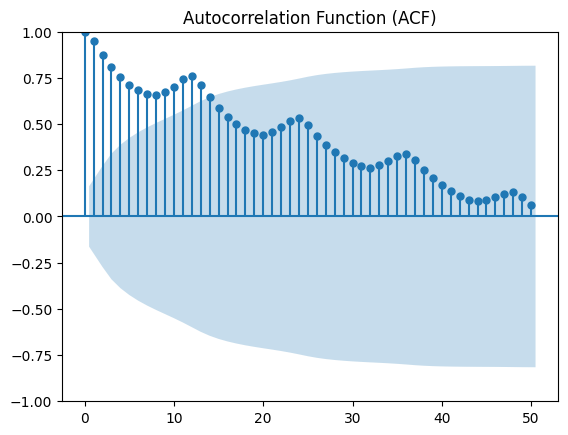

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(data, lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show();

### Інтерпретація графіка автокореляційної функції (ACF)

Основні компоненти графіка ACF:

1. **Стовпчики**:
   - Кожен стовпчик на графіку представляє значення автокореляції для певного лагу (інтервалу часу).
   - Висота стовпчика вказує на величину автокореляції.

2. **Горизонтальна вісь (Lag)**:
   - Вісь $x$ показує лаг (кількість періодів зсуву) від 0 до 50.
   - Лаг 0 завжди має автокореляцію 1, оскільки це кореляція рядка із самим собою.

3. **Вертикальна вісь (ACF)**:
   - Вісь $y$ показує значення автокореляції, які можуть змінюватися від -1 до 1.
   - Значення автокореляції можуть бути позитивними чи негативними.

4. **Синя зона**:
   - Синя затінена область представляє довірчий інтервал (зазвичай 95% довірчий інтервал).
   - Автокореляційні значення, які виходять за межі цієї зони, вважаються статистично значущими.

#### Інтерпретація отриманого нами графіка:

1. **Лаги до приблизно 20**:
   - Значення автокореляції зменшуються з лагом, але залишаються значущими, оскільки вони виходять за межі синьої зони. Це свідчить про сильну позитивну автокореляцію на малих лагах.

2. **Періодичність**:
   - Після перших кількох лагів можна спостерігати коливання автокореляції, що вказує на наявність сезонних патернів у даних. Наприклад, автокореляція зменшується, потім збільшується знову через певні інтервали.

3. **Поведінка після 30**:
   - На лагах після 30 автокореляція поступово зменшується і стає менш значущою, оскільки значення знаходяться в межах синьої зони. Це означає, що зв'язок між значеннями ряду з великим лагом стає слабшим і менш значущим.

## Часткова автокореляція

Для досліджень часових рядів нам іноді також хочеться подивитись, як повʼязані між собою історичні дані з певним проміжком часу між ними але без впливу проміжних значень.

**Часткова автокореляція** (Partial Autocorrelation) як раз вимірює кореляцію між значеннями часового ряду з певним лагом, при цьому **усуваючи вплив всіх проміжних лагів**. Іншими словами, часткова автокореляція на лагу $ k $ показує чисту кореляцію між значенням у момент часу $ t $ і значенням у момент часу $ t-k $, усунувши вплив всіх значень між ними.

#### Зв'язок між автокореляцією та частковою автокореляцією

- **Автокореляція (ACF)**: Вимірює кореляцію між значеннями часового ряду для всіх лагів. Вона включає непрямі ефекти через проміжні лаги.
- **Часткова автокореляція (PACF)**: Вимірює кореляцію між значеннями часового ряду для конкретного лагу, усунувши вплив всіх проміжних лагів.

#### Навіщо потрібна часткова автокореляція?

Часткова автокореляція корисна для визначення правильного порядку авторегресійної моделі (AR) в аналізі часових рядів. Вона допомагає виявити, наскільки значимі залежності між значеннями на конкретних лагах, що дозволяє краще зрозуміти структуру даних та побудувати більш точні моделі прогнозування.



<Figure size 1000x600 with 0 Axes>

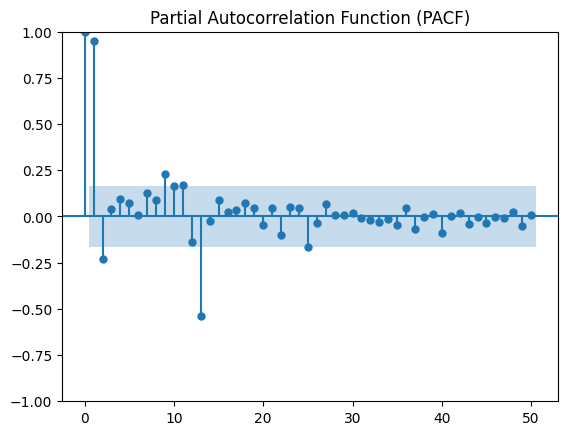

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Візуалізація часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(data, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()



### Інтерпретація графіка PACF

1. **Перший лаг (lag 1)**:
   - Якщо перше значення PACF є значущим (виходить за межі довірчого інтервалу), це означає, що є сильна кореляція між значеннями часового ряду з лагом 1, усунувши вплив всіх інших лагів.

2. **Наступні лаги**:
   - Значущі значення на наступних лагах показують, що кореляція на цих лагах залишається значущою, навіть усунувши вплив проміжних лагів.




## Стаціонарність

Важливим поняттям в аналізі часових рядів є стаціонарність. Розглянемо, що це таке.

**Стаціонарність** – це властивість часового ряду, коли його статистичні характеристики (середнє, дисперсія) залишаються постійними з часом. Стаціонарні ряди є більш передбачуваними і простіше моделюються.

Стаціонарний ряд має:
- Постійне середнє
- Постійну дисперсія
- Автокореляція залежить лише від лагу, а не від часу

![](https://osu-wams-blogs-uploads.s3.amazonaws.com/blogs.dir/2115/files/2022/02/Screen-Shot-2022-02-28-at-12.10.04-PM.png)


Як же нам виявити, чи ряд є стаціонарним, крім як візуально? Існують статистичні тести.

### Тести на стаціонарність

#### ADF тест (Augmented Dickey-Fuller Test)
ADF тест використовується для перевірки гіпотези про наявність одиничного кореня в часовому ряді, що свідчить про нестаціонарність.

- **Нульова гіпотеза (H0)**: Ряд має одиничний корінь (нестабільний).
- **Альтернативна гіпотеза (H1)**: Ряд стаціонарний.

Результат тесту дає p-значення. Якщо p-значення менше за обраний рівень значущості (наприклад, 0.05), нульова гіпотеза відхиляється, і ряд вважається стаціонарним.

### Методи перетворення для досягнення стаціонарності

#### Диференціювання
Диференціювання – це метод, який використовується для видалення тренду і сезонності з часового ряду. Перший порядок диференціювання обчислюється як різниця між поточним і попереднім значенням ряду.

$$ y'_t = y_t - y_{t-1} $$

Це дозволяє отримати новий ряд, який може бути більш стаціонарним.

#### Логарифмування
Логарифмування використовується для стабілізації дисперсії, особливо коли варіація значень часового ряду збільшується з часом. Логарифмування зменшує вплив великих значень і може допомогти зробити ряд більш стаціонарним.

$$ y'_t = \log(y_t) $$


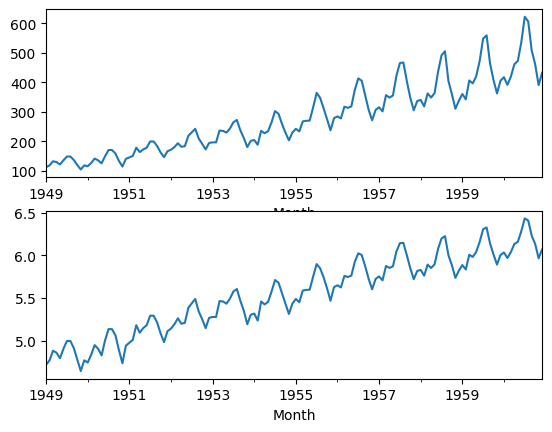

In [ ]:
plt.subplot(2, 1, 1)
data.Passengers.plot()
plt.subplot(2, 1, 2)
np.log(data.Passengers).plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Виконання ADF тесту
result = adfuller(data['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


**Інтерпретація**:
- Значення ADF статистики (0.815369) є більшим за всі критичні значення, тому ми не можемо відхилити нульову гіпотезу. Це означає, що ряд не є стаціонарним.
- Значення p-value (0.991880) є більшим за 0.05, тому ми не можемо відхилити нульову гіпотезу про нестабільність ряду.

#### Приклад перетворення ряду для досягнення стаціонарності

Якщо ряд не є стаціонарним, ми можемо застосувати трансформації, такі як диференціювання, щоб зробити його стаціонарним.

1. **Диференціювання ряду**:


In [ ]:
# data['Passengers'].diff()

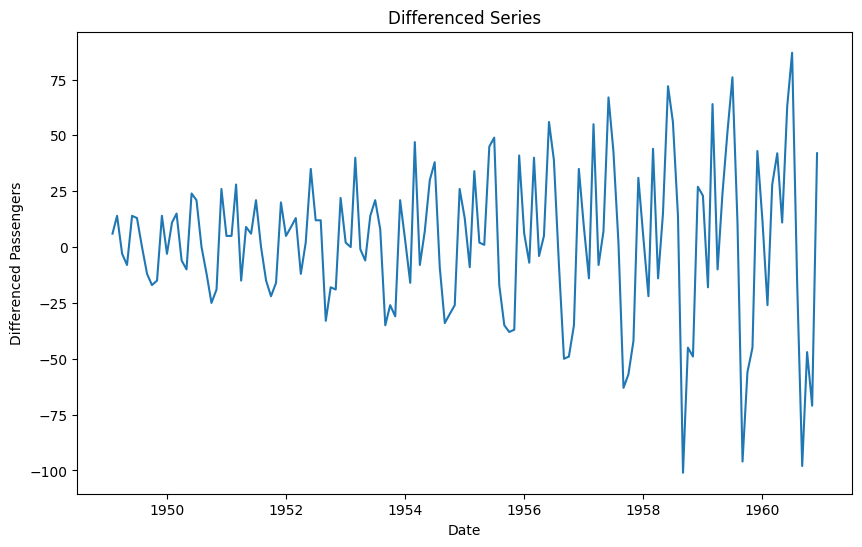

In [ ]:
data['Diff'] = data['Passengers'].diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(data['Diff'])
plt.title('Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Passengers')
plt.show()


2. **Повторний ADF тест на диференційованому ряду**:


In [ ]:
# Виконання ADF тесту на продиференційованому ряді
result = adfuller(data['Diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Отриманий часовий ряд є стаціонарним.
Як можна було б прологарифмувати і продиференціювати ряд:

<Axes: xlabel='Month'>

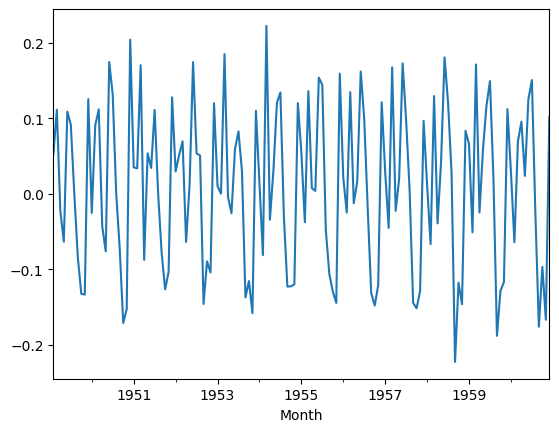

In [ ]:
np.log1p(data['Passengers']).diff().dropna().plot()

# Огляд бібліотеки Darts

**[Darts](https://unit8co.github.io/darts/)** - це бібліотека Python для роботи з часовими рядами, яка включає безліч моделей, від класичних статистичних до сучасних глибоких нейронних мереж. Вона дозволяє легко здійснювати підготовку даних, побудову моделей, тренування, прогнозування та оцінку моделей.


## Встановлення Darts
Є два основні способи.

За допомогою pip:
```
pip install darts
```

За допомогою conda:
```
conda install -c conda-forge -c pytorch u8darts-all
```

Зверніться до [детального посібника з встановлення](https://github.com/unit8co/darts#installation-guide), якщо у вас виникнуть проблеми або ви хочете встановити іншу версію (уникаючи певних залежностей).

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 247.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 36.8 MB/s eta 0:00


## Побудова та маніпулювання `TimeSeries`
`TimeSeries` є основним класом даних у Darts. `TimeSeries` представляє одновимірний або багатовимірний часовий ряд з відповідним часовим індексом. Часовий індекс може бути типу `pandas.DatetimeIndex` (містить дати та часи) або типу `pandas.RangeIndex` (містить цілі числа, корисні для представлення послідовних даних без конкретних часових міток). У деяких випадках `TimeSeries` може навіть представляти *ймовірнісні* ряди, щоб, наприклад, отримати довірчі інтервали. Усі моделі в Darts споживають `TimeSeries` і виробляють `TimeSeries`.

`TimeSeries` можна легко побудувати або зчитати за допомогою кількох фабричних методів:

* З усього Pandas `DataFrame`, використовуючи `TimeSeries.from_dataframe()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_dataframe)).
* З часовим індексом та масивом відповідних значень, використовуючи `TimeSeries.from_times_and_values()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_times_and_values)).
* З масиву значень NumPy, використовуючи `TimeSeries.from_values()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_values)).
* З Pandas `Series`, використовуючи `TimeSeries.from_series()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_series)).
* З `xarray.DataArray`, використовуючи `TimeSeries.from_xarray()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_xarray)).
* З CSV файлу, використовуючи `TimeSeries.from_csv()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_csv)).
* Створення кількох `TimeSeries` за групами з Pandas `DataFrame`, використовуючи `TimeSeries.from_group_dataframe()` ([документація](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_group_dataframe)).

Нижче ми отримуємо `TimeSeries`, безпосередньо завантаживши вже існуючий набір даних в pandas.DataFrame у Darts:

In [ ]:
data.head()

,Passengers,Diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [ ]:
from darts import TimeSeries

# Завантаження даних в darts, індекс був перетворений в Darts індекс автоматично
series = TimeSeries.from_dataframe(data, value_cols='Passengers')

In [ ]:
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)> Size: 1kB
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 8B 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

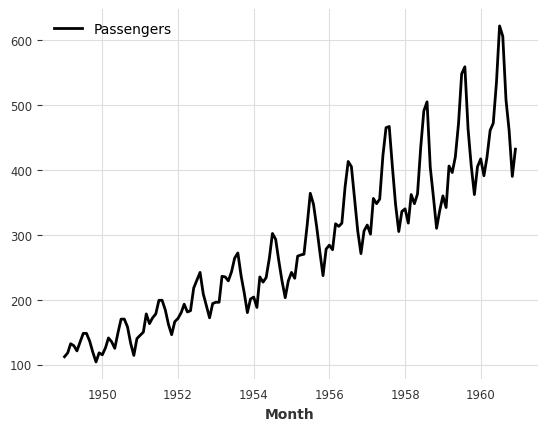

In [ ]:
series.plot()

## Деякі операції з `TimeSeries`
`TimeSeries` підтримує різні види операцій - ось кілька прикладів.

**розбиття**

Ми також можемо розбити на частину ряду, на `Timestamp` (мітка часу) в pandas або на цілочислове значення індексу.

<Axes: xlabel='Month'>

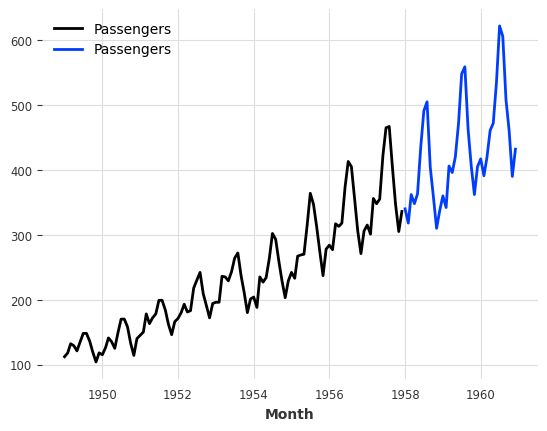

In [ ]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

**слайсинг (slicing):**

<Axes: xlabel='Month'>

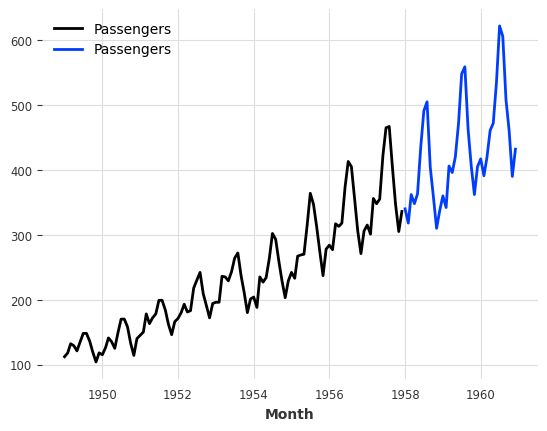

In [ ]:
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

**арифметичні операції:**

<Axes: xlabel='Month'>

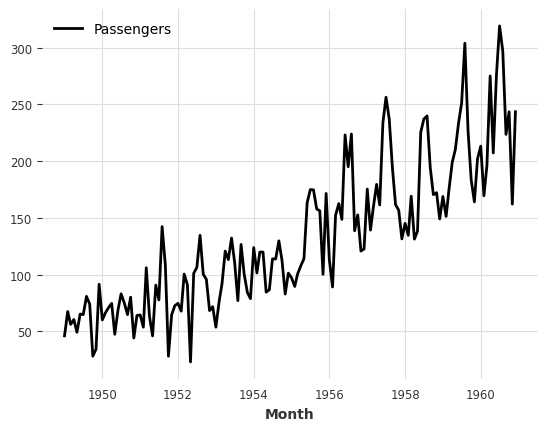

In [ ]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

**стекінг (stacking)**

Конкатенація нового виміру для створення нової єдиної багатовимірної серії.

<Axes: xlabel='Month'>

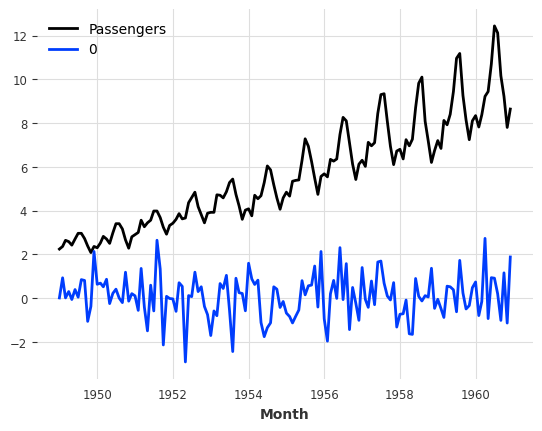

In [ ]:
(series / 50).stack(series_noise).plot()

**відображення (mapping):**

<Axes: xlabel='Month'>

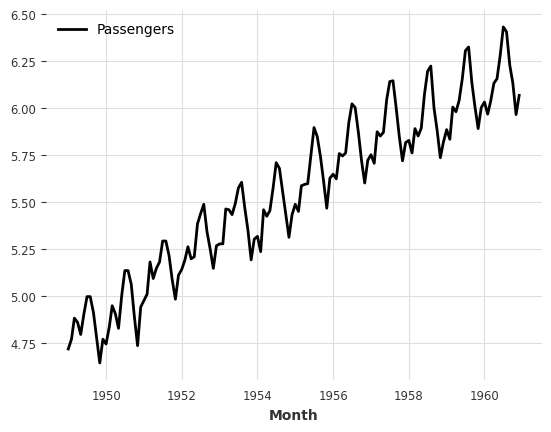

In [ ]:
series.map(np.log).plot()

**відображення як на часові мітки, так і на значення:**

<Axes: xlabel='Month'>

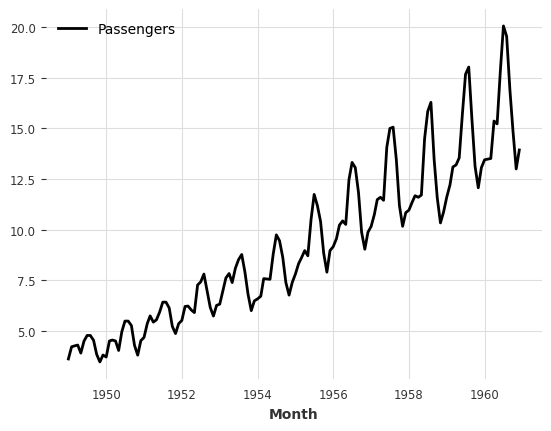

In [ ]:
series.map(lambda ts, x: x / ts.days_in_month).plot()

**Додавання деякого атрибуту дати та часу як додаткового виміру (отримання багатовимірного ряду):**

<Axes: xlabel='Month'>

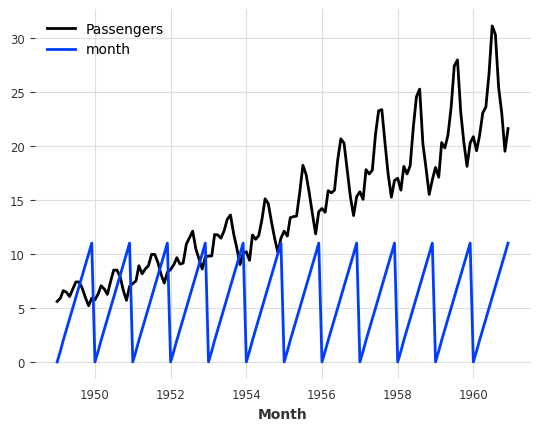

In [ ]:
(series / 20).add_datetime_attribute("month").plot()

**Додавання деяких бінарних компонентів свят:**

<Axes: xlabel='Month'>

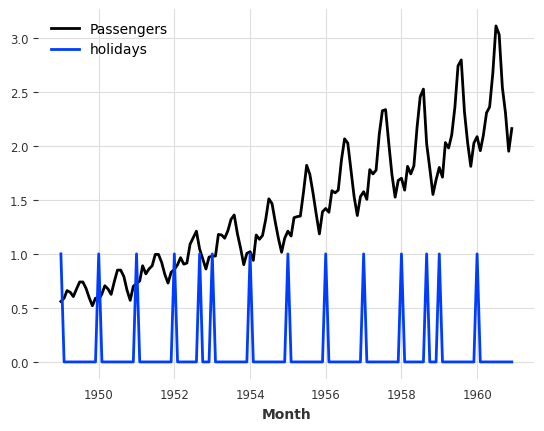

In [ ]:
(series / 200).add_holidays("US").plot()

**диференціювання (differencing):**

<Axes: xlabel='Month'>

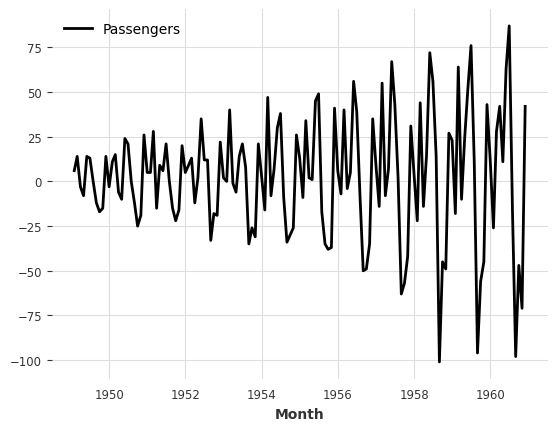

In [ ]:
series.diff().plot()

**Заповнення відсутніх значень (використовуючи функцію `utils`).**

Відсутні значення представлені як `np.nan`.

<Axes: xlabel='time'>

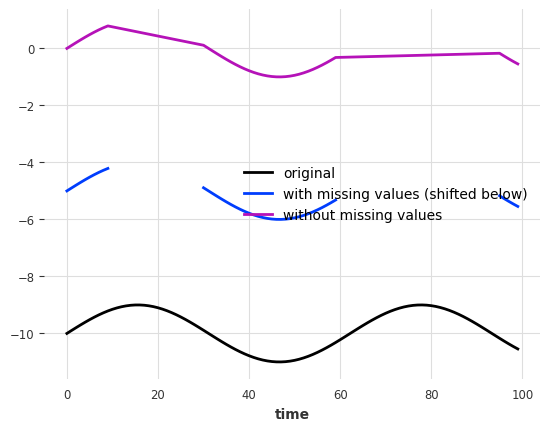

In [ ]:
from darts.utils.missing_values import fill_missing_values

original_values = np.sin(np.linspace(0, 10, 100))
values = original_values.copy()
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)
original_values_series_  = TimeSeries.from_values(original_values)

(original_values_series_-10).plot(label='original')
(series_ - 5).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## Створення навчальної та валідаційної серій
Для подальших дій ми розділимо наш `TimeSeries` на навчальну та валідаційну серії. Примітка: загалом, також є гарною практикою залишати тестову серію осторонь і не торкатися її до кінця процесу. Тут ми просто створимо навчальну та валідаційну серії для простоти.

Навчальна серія буде `TimeSeries`, що містить значення до січня 1958 року (виключно), а валідаційна серія - `TimeSeries`, що містить решту:

<Axes: xlabel='Month'>

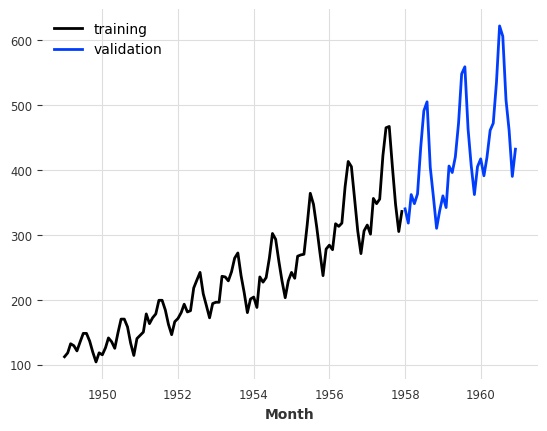

In [ ]:
train, val = series.split_before(pd.Timestamp("1958-01-01"))
train.plot(label="training")
val.plot(label="validation")

# Навчання моделей прогнозування та створення прогнозів

Сучасні методи аналізу та прогнозування часових рядів дозволяють робити прогнози і враховувати складні залежності в даних. Багато сучасних методів реалізовано в бібліотеці Darts.

Основні методи аналізу часових рядів, які використовуються в індустрії:

1. **Exponential Smoothing** - метод прогнозування, який враховує попередні спостереження з експоненційно зменшуваною вагою.
2. **Theta** - проста модель, яка розкладає часовий ряд на кілька Theta-ліній і використовує експоненційне згладжування для кожної Theta-лінії.

3. **ARIMA/SARIMA** - класичні статистичні моделі для аналізу та прогнозування даних.
4. **Прогнозування на основі Facebook Prophet** - інструмент, розроблений Facebook для прогнозування часових рядів з урахуванням сезонності.
5. **Рекурентні нейронні мережі (RNN та LSTM)** - глибоке навчання для аналізу даних, які залежать від часу.
6. **Трансформери та механізми attention** - новітні механізми глибокого навчання, які покращують здатність моделей досягати високої точності в складних задачах прогнозування.

Про них і поговоримо далі.


## Гра з іграшковими моделями

У Darts є колекція ["наївних"](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.global_baseline_models.html) базових моделей, які можуть бути дуже корисними для отримання уявлення про мінімальну точність, яку можна очікувати. Наприклад, модель `NaiveSeasonal(K)` завжди "повторює" значення, яке відбулося `K` кроків тому.

У своїй найнаївнішій формі, коли `K=1`, ця модель просто завжди повторює останнє значення навчальної серії:

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




<Axes: xlabel='Month'>

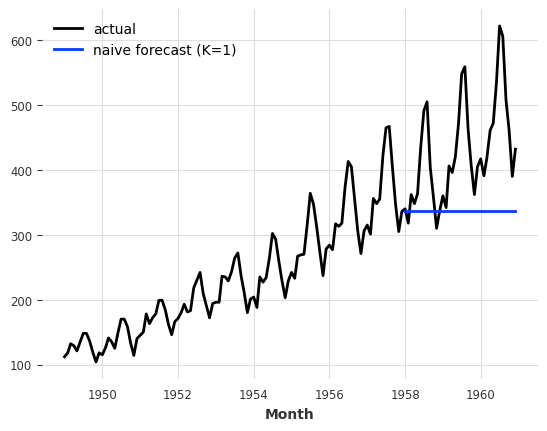

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

Дуже легко підганяти моделі та створювати прогнози на `TimeSeries`. Усі моделі мають функції `fit()` та `predict()`. Це схоже на [Scikit-learn](https://scikit-learn.org/), за винятком того, що це специфічно для часових рядів. Функція `fit()` приймає як аргумент навчальний часовий ряд, на якому буде підганятися модель, а функція `predict()` приймає як аргумент кількість часових кроків (після закінчення навчального ряду), на які буде здійснюватися прогноз.

### Інспекція сезонності
Наша модель вище, можливо, трохи занадто наївна. Ми вже можемо покращити її, використовуючи сезонність у даних. Здається досить очевидним, що дані мають річну сезонність, що ми можемо підтвердити, подивившись на автокореляційну функцію (ACF), і виділивши лаг `m=12`:

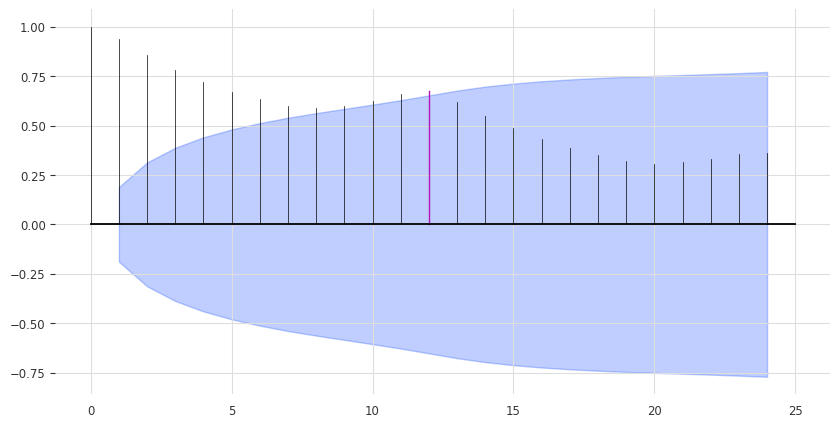

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)

ACF показує пік при x = 12, що вказує на річну сезонну тенденцію (виділено червоним). Синя зона визначає значущість статистики для рівня довіри $\alpha = 5\%$. Ми також можемо провести статистичну перевірку сезонності для кожного кандидата періоду `m`:

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


### Менш наївна модель
Спробуємо модель `NaiveSeasonal` з сезонністю 12:

<Axes: xlabel='Month'>

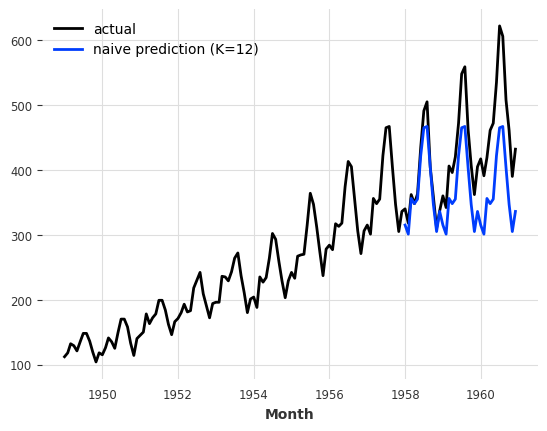

In [ ]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=12)")

Це краще, але ми все ще пропускаємо тренд. На щастя, існує ще одна наївна базова модель, яка захоплює тренд, і називається вона `NaiveDrift`. Ця модель просто створює лінійні прогнози, з нахилом, який визначається першими та останніми значеннями навчального набору:

<Axes: xlabel='Month'>

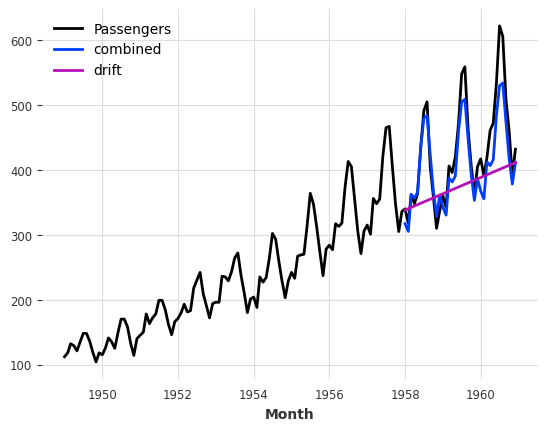

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

Що сталося? Ми просто підігнали наївну модель дрейфу і додали її прогноз до сезонного прогнозу, який ми мали раніше. Ми також віднімаємо останнє значення з навчального набору від результату, щоб отриманий комбінований прогноз починався з правильного зсуву.

## Обчислення метрик помилки

Це вже виглядає як досить пристойний прогноз, і ми ще не використовували жодної ненаївної моделі. Насправді, будь-яка модель повинна бути здатна перевершити це.

Отже, яку помилку нам потрібно буде перевершити? Ми будемо використовувати [середню абсолютну відсоткову помилку (Mean Absolute Percentage Error, MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (зверніть увагу, що на практиці часто є вагомі причини *не* використовувати MAPE - ми використовуємо її тут, оскільки вона досить зручна і незалежна від масштабу). У Darts це простий виклик функції:

In [ ]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


`darts.metrics` містить набагато більше метрик для порівняння часових рядів. Метрики будуть порівнювати лише спільні частини рядів, коли два ряди не вирівняні, і паралелізувати обчислення для великої кількості пар рядів - але не будемо забігати наперед.

## Швидко спробуйте кілька моделей
Darts створений для того, щоб легко тренувати та перевіряти кілька моделей у єдиний спосіб. Давайте навчимо ще кілька моделей і обчислимо їх відповідні MAPE на валідаційному наборі:

In [ ]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)


fit_eval_model(ExponentialSmoothing())
fit_eval_model(AutoARIMA())
fit_eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


Тут ми створили ці моделі лише з їхніми параметрами за замовчуванням. Ми, ймовірно, можемо досягти кращих результатів, якщо налаштуємо їх під нашу задачу. Давайте спробуємо метод Тета (Theta method).

Що ж це за моделі ми використали і взагалі, якими моделями прогнозуються часові ряди?

# Моделі для прогнозування часових рядів

## XGBoost
Класно знову бачити старих друзів! Так, ми можемо використати XGBoost для прогнозування часових рядів. Як? Стоворивши з самого ряда нові ознаки і додавши екзогенні.
Перед оглядом параметрів методу маємо познайомитись з новим поняттям.

### Що таке коваріати?

**Коваріати** - це додаткові змінні, які можуть використовуватися в моделях часових рядів для покращення точності прогнозування. Вони включають будь-які зовнішні фактори, які можуть впливати на цільовий часовий ряд. Це і є наші незалежні змінні або фічі в класичному машинному навчанні на статичних даних.

### Типи коваріатів

1. **Минулі коваріати (Past covariates)** - значення, що передують поточному значенню цільового ряду. Наприклад, історичні погодні умови для прогнозування врожаю.

2. **Майбутні коваріати (Future covariates)** - значення, що будуть відомі в майбутньому. Наприклад, плани виробництва або заплановані маркетингові акції, запланований бюджет, який буде вкладено в трафік.

3. **Статичні коваріати (Static covariates)** - фіксовані значення, які залишаються незмінними для всіх спостережень. Наприклад, географічне розташування або тип продукту.


### Основні параметри XGBModel у Darts

- **lags**: Затримки значень цільового ряду, що використовуються для прогнозування наступного кроку. Може бути цілим числом, списком або словником.
- **lags_past_covariates**: Затримки значень минулих ковариатів, що використовуються для прогнозування наступного кроку. Може бути цілим числом, списком або словником.
- **lags_future_covariates**: Затримки значень майбутніх ковариатів, що використовуються для прогнозування наступного кроку. Може бути кортежем, списком або словником.
- **output_chunk_length**: Кількість кроків часу, прогнозованих одночасно (періодами) внутрішньою моделлю.
- **output_chunk_shift**: Кількість кроків для зміщення початку вихідного фрагмента в майбутнє відносно кінця вхідного фрагмента.
- **add_encoders**: Можливість автоматичного генерації великої кількості минулих і майбутніх ковариатів за допомогою додавання індексних енкодерів та/або користувацьких функцій.
- **random_state**: Контролює випадковість у процесі тренування та для вибірки. За замовчуванням: None.
- **multi_models**: Якщо True, окрема модель буде навчена для кожного майбутнього кроку. Якщо False, навчена одна модель для прогнозування на крок 'output_chunk_length'.
- **use_static_covariates**: Чи повинна модель використовувати статичні ковариати.

Дуже прийнято, якщо подаємо ряд в xgboost ще генерувати фічі з дати і покажу також, як це робиться.

In [ ]:
train.pd_dataframe()

component,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1957-08-01,467.0
1957-09-01,404.0
1957-10-01,347.0


In [ ]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  # df["hour"] = df['Month'].dt.hour
  # df["dayofweek"] = df['Month'].dt.dayofweek
  df["quarter"] = df['Month'].dt.quarter
  # df["month"] = df['Month'].dt.month
  df["year"] = df['Month'].dt.year
  df["dayofyear"] = df['Month'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  # df["dayofmonth"] = df['Month'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=12,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

array([[0.68407327],
       [0.67232114],
       [0.7705617 ],
       [0.7820361 ],
       [0.7781621 ],
       [0.91478926]], dtype=float32)

In [ ]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (Month: 6, component: 1, sample: 1)> Size: 24B
array([[[352.31857]],

       [[348.05255]],

       [[383.7139 ]],

       [[387.8791 ]],

       [[386.47287]],

       [[436.06848]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 48B 1958-01-01 1958-02-01 ... 1958-06-01
  * component  (component) object 8B 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

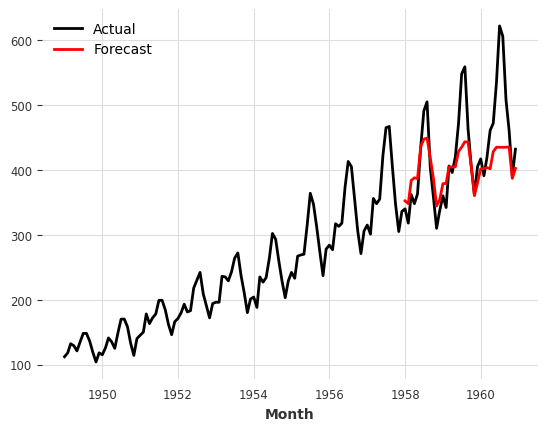

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 8.49%


In [ ]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast);

Тут видно, що втрачає тренд ця моделька. Тому тут були б ліпше результати, якби ми тренувались постійно на всіх наявних даних і прогнозували вперед скажімо на 1/6/12 кроків.



## Exponential Smoothing

**Exponential Smoothing** - це простий метод прогнозування часових рядів, який враховує попередні спостереження з експоненційно зменшуваною вагою.

#### Основні типи Exponential Smoothing:
- **Simple Exponential Smoothing (SES)**: підходить для рядів без тренду та сезонності.
  $$ \hat{Y}_t = \alpha Y_{t-1} + (1 - \alpha) \hat{Y}_{t-1} $$
  де $ \alpha $ - згладжувальний параметр.
- **Holt’s Linear Trend Model**: враховує тренд у часовому ряду.
  $$ \hat{Y}_t = \alpha Y_{t-1} + (1 - \alpha) (\hat{Y}_{t-1} + b_{t-1}) $$
  $$ b_t = \beta (\hat{Y}_t - \hat{Y}_{t-1}) + (1 - \beta) b_{t-1} $$
  де $ \beta $ - згладжувальний параметр тренду.
- **Holt-Winters Seasonal Model**: враховує як тренд, так і сезонність.
  $$ \hat{Y}_t = \alpha (Y_{t} - S_{t-s}) + (1 - \alpha) (\hat{Y}_{t-1} + b_{t-1}) $$
  $$ b_t = \beta (\hat{Y}_t - \hat{Y}_{t-1}) + (1 - \beta) b_{t-1} $$
  $$ S_t = \gamma (Y_{t} - \hat{Y}_t) + (1 - \gamma) S_{t-s} $$
  де $ \gamma $ - згладжувальний параметр сезонності, $ s $ - сезонний період.


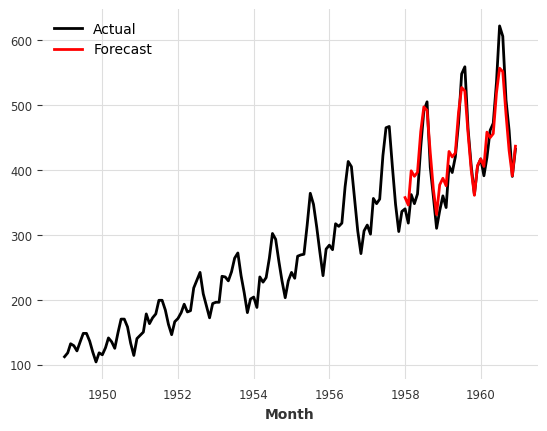

model ExponentialSmoothing() obtains MAPE: 5.11%


In [ ]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

#### ARIMA

**ARIMA** (AutoRegressive Integrated Moving Average) - це модель, яка поєднує три ключові компоненти: авторегресію (AR), інтеграцію (I) та ковзне середнє (MA).

1. **AR (AutoRegressive)**:
   - Використовує залежність між поточним значенням і попередніми значеннями часового ряду.
   - Формула AR(p):
     $$ Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \epsilon_t $$
     де $ \phi $ - коефіцієнти авторегресії, $ \epsilon_t $ - випадкова помилка.

2. **I (Integrated)**:
   - Включає крок диференціювання ряду для досягнення стаціонарності (сталого середнього).
   - Формула I(d):
     $$ Y_t' = Y_t - Y_{t-1} $$
     де $ d $ - порядок диференціювання.

3. **MA (Moving Average)**:
   - Використовує залежність між поточним значенням і попередніми помилками прогнозу.
   - Формула MA(q):
     $$ Y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q} $$
     де $ \theta $ - коефіцієнти ковзного середнього.

**ARIMA(p, d, q)** об'єднує ці компоненти:
$$ Y_t = c + \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} $$

Детальне пояснення на прикладі [тут](https://towardsdatascience.com/arima-simplified-b63315f27cbc).

**Приклад використання ARIMA в Darts**:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



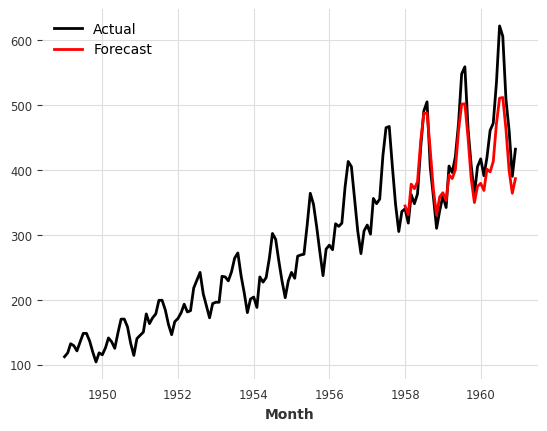

model ARIMA(q=1) obtains MAPE: 6.56%


In [ ]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=12, d=1, q=1) # try p=12
fit_and_plot(model, series, train, val)



ARIMA є широко використовуваною моделлю прогнозування завдяки своїй простоті та здатності узагальнювати нестаціонарні ряди.

Однак, важливо розуміти, коли використовувати ARIMA, а коли ні. ARIMA погано працює з сезонними даними. Наприклад, прогнозування врожайності або продажів з наявною сезонністю!

У цих випадках краще використовувати сезонну ARIMA.

В нашому випадку ARIMA б значно ліпше спрацювала для прогнозування тренду (наприклад, з адитивної декомпозиції)

In [ ]:
df_additive.head()

,Passengers,trend,detrended,month,seasonality,resid,trend_26
Month,,,,,,,
1949-01-01,112,NaN,NaN,1,-30.825175,NaN,NaN
1949-02-01,118,NaN,NaN,2,-42.027972,NaN,NaN
1949-03-01,132,NaN,NaN,3,-4.139860,NaN,NaN
1949-04-01,129,NaN,NaN,4,-6.944056,NaN,NaN
1949-05-01,121,NaN,NaN,5,-0.699301,NaN,NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



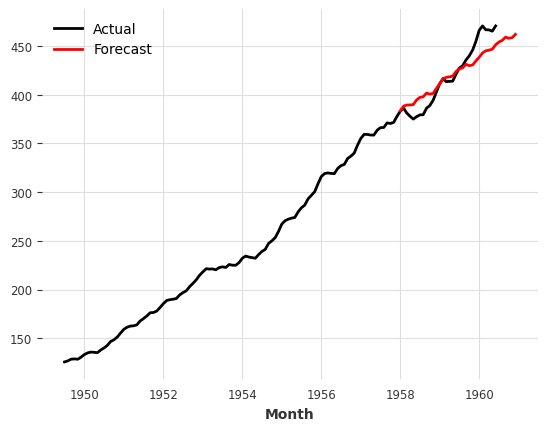

model ARIMA(q=1) obtains MAPE: 2.63%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
trend_series = TimeSeries.from_dataframe(df_additive, value_cols='trend')
trend_train, trend_val = trend_series.split_before(pd.Timestamp("1958-01-01"))

model = ARIMA(p=12, d=1, q=1) # try p = 12
fit_and_plot(model, trend_series, trend_train, trend_val)
model.fit(trend_train)
forecast = model.predict(36)

Після того, як ми спрогнозували тренд, ми можемо додати до нього компонет сезонності, який за нашим розкладом у нас вийшов однаковий для кожного місяця кожного року.

<Axes: xlabel='Month'>

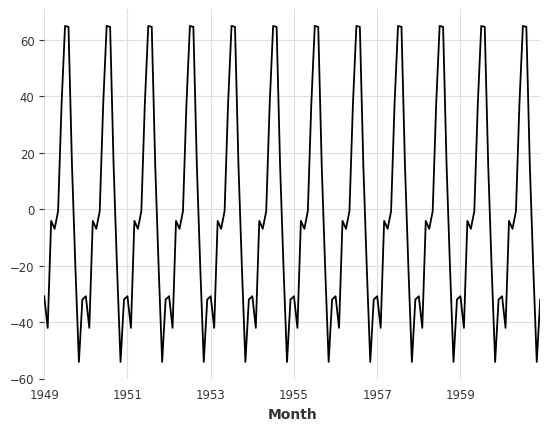

In [ ]:
df_additive['seasonality'].plot()

In [ ]:
seasonal_series = TimeSeries.from_dataframe(df_additive, value_cols='seasonality')

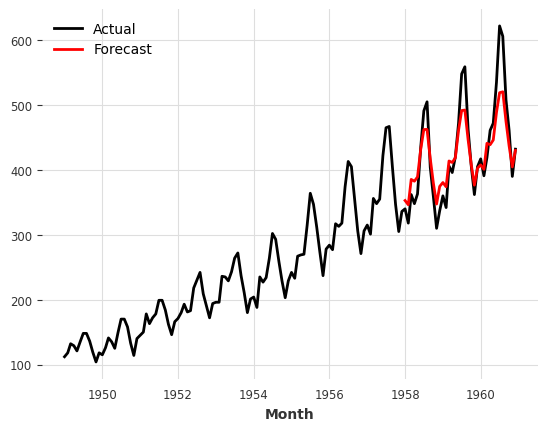

In [ ]:
# Візуалізація результатів
plot_results(series, forecast+seasonal_series[-36:])

In [ ]:
eval_forecast(model, val, forecast+seasonal_series[-36:])

model ARIMA(q=1) obtains MAPE: 5.93%


5.930979876047603

### SARIMA/SARIMAX

**SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) — це розширена модель ARIMA, яка включає сезонні компоненти та екзогенні змінні (регресори).

1. **Сезонні компоненти** моделюють сезонні патерни в даних. Формула сезонних компонентів (P, D, Q, s):
$$ Y_t = c + \Phi_1 Y_{t-s} + \Phi_2 Y_{t-2s} + \dots + \Phi_P Y_{t-sP} + \epsilon_t + \Theta_1 \epsilon_{t-s} + \dots + \Theta_Q \epsilon_{t-sQ}$$

  де $ s $ - сезонний період, $ P, D, Q $ - сезонні компоненти.

2. **Екзогенні змінні (регресори)** використовуються для моделювання впливу зовнішніх факторів на часовий ряд. Формула з екзогенними змінними:
     $$
     Y_t = c + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \dots + \beta_k X_{t-k} + \epsilon_t
     $$
     де $ \beta $ - коефіцієнти регресорів, $ X $ - екзогенні змінні.а

Тут не врахована сезонність, тому модель слабенька. А також ми задали параметри базові, які не підходять в цьому випадку.

SARIMAX реалізований в Darts немає як виділеного методу в Darts, тому викличемо цю модель з statsmodels.

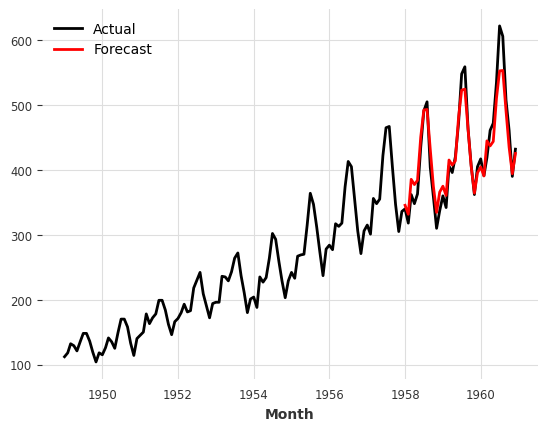

In [ ]:
# Створення екзогенного часового ряду (наприклад, економічні показники)
exog = pd.DataFrame({
    'exog_var': np.random.randn(len(data))
}, index=data.index)
exog_series = TimeSeries.from_dataframe(exog)

# Поділ на тренувальні та тестові дані
train, test = series.split_before(pd.Timestamp('1958-01-01'))
train_exog, test_exog = exog_series.split_before(pd.Timestamp('1958-01-01'))

# Побудова та тренування моделі SARIMAX
model = ARIMA(1, 1, 1, seasonal_order=(1, 1, 1, 12))
model.fit(train, future_covariates=train_exog)

# Прогнозування
forecast = model.predict(len(test), future_covariates=test_exog)

# Візуалізація результатів
plot_results(series, forecast)

In [ ]:
eval_forecast(model, val, forecast);

model ARIMA(p=1, q=1, seasonal_order=(1, 1, 1, 12)) obtains MAPE: 4.14%


Отримали метрику ліпшу, ніж дали попередні моделі!




### AutoARIMA

**AutoARIMA** - це автоматизована версія моделі ARIMA, яка автоматично обирає оптимальні значення параметрів (p, d, q) на основі критеріїв інформації, таких як AIC або BIC. AutoARIMA автоматично підганяє модель ARIMA, але не завжди то буде краще за підібрану вручну.



In [ ]:
# ?AutoARIMA

AutoARIMA(add_encoders=None, start_p=8, max_p=12, start_q=1)

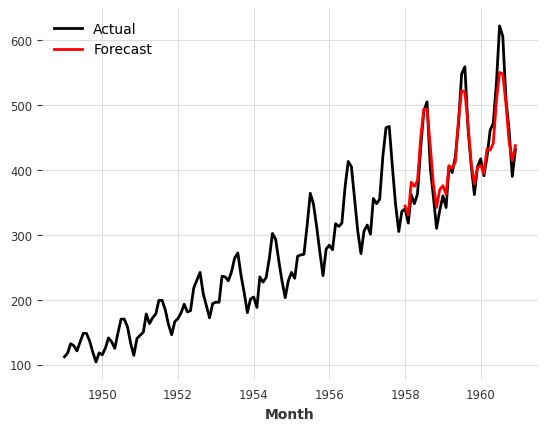

In [ ]:
# Побудова та тренування моделі AutoArima
model = AutoARIMA(start_p=8, max_p=12, start_q=1) # спробуйте стартувати з інших значень і перегляньте, що виходить
model.fit(train)

display(model)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast)

In [ ]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:              SARIMAX(12, 1, 3)   Log Likelihood                -394.270
Date:                Mon, 05 Aug 2024   AIC                            822.541
Time:                        19:32:01   BIC                            867.979
Sample:                             0   HQIC                           840.961
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7626      5.764      1.173      0.241      -4.535      18.060
ar.L1         -0.0788      0.270     -0.292      0.770      -0.608       0.450
ar.L2         -0.3601      0.198     -1.822      0.069      -0.748       0.027
ar.L3         -0.0873      0.261     -0.335      0.738      -0.599       0.424
ar.L4         -0.3321      0.179     -1.856      0.064      -0.683       0.019
ar.L5         -0.1093      0.223     -0.490      0.624      -0.546       0.328
ar.L6         -0.2999      0.178     -1.690      0.091      -0.648       0.048
ar.L7         -0.1485      0.229     -0.647      0.517      -0.598       0.301
ar.L8         -0.3088      0.184     -1.680      0.093      -0.669       0.052
ar.L9         -0.1343      0.222     -0.605      0.545      -0.569       0.301
ar.L10        -0.3309      0.196     -1.685      0.092      -0.716       0.054
ar.L11        -0.0845      0.231     -0.366      0.715      -0.537       0.368
ar.L12         0.6019      0.186      3.243      0.001       0.238       0.966
ma.L1         -0.0937      0.295     -0.318      0.751      -0.672       0.484
ma.L2          0.2900      0.207      1.402      0.161      -0.115       0.695
ma.L3         -0.1922      0.244     -0.789      0.430      -0.670       0.286
sigma2        79.1665     14.905      5.311      0.000      49.953     108.380
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.71   Prob(JB):                         0.44
Heteroskedasticity (H):               1.66   Skew:                             0.30
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
eval_forecast(model, val, forecast);

model AutoARIMA(start_p=8, max_p=12, start_q=1) obtains MAPE: 4.35%



### Theta

**Theta** - це проста, але ефективна модель для прогнозування часових рядів, яка розкладає ряд на кілька Theta-ліній і використовує їх для створення прогнозу.

Тета-модель базується на декомпозиції. Ми знаємо, що часові ряди можна розкласти на три компоненти: трендовий компонент, сезонний компонент та залишки.

Таким чином, розумним підходом є декомпозиція ряду на кожну з його складових, прогнозування кожної складової на майбутнє та об'єднання прогнозів кожної складової для створення остаточного прогнозу.

На жаль, на практиці це не завжди працює, особливо тому, що важко виокремити залишки та спрогнозувати їх.

Отже, тета-модель є розвитком цієї ідеї, але вона спирається на декомпозицію ряду на **довгостроковий** компонент і **короткостроковий** компонент.

З формальної точки зору, тета-модель базується на концепції модифікації локальної кривизни часового ряду. Цією модифікацією керує параметр, який називається тета (звідси і назва - тета-модель). Ця модифікація застосовується до другої різниці ряду, тобто він диференціюється двічі.

Коли тета знаходиться між 0 і 1, ряд «здувається». Це означає, що короткострокові коливання є меншими, і ми робимо акцент на довгострокових ефектах. Коли тета досягає 0, ряд перетворюється на лінійну лінію регресії. Ця поведінка показана на рисунку нижче.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*koWNcK8OQmbr1CPEhSjWpg.png)

З іншого боку, коли тета більша за 1, то короткострокові коливання збільшуються, і тому ми наголошуємо на короткострокових ефектах. У такому випадку ми також говоримо, що ряд є «роздутим». Ця поведінка показана на рисунку нижче.
![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*x-kbFl6WCVjE9SZWQ7KCKg.png)

Для кожного значення тета ми створюємо «тета-лінію». Теоретично, ми можемо створити скільки завгодно тета-ліній, спрогнозувати кожну з них на майбутнє і об'єднати їх для остаточного прогнозу.

На практиці ми часто використовуємо лише дві тета-лінії: одну, де тета дорівнює 0, і одну, де тета дорівнює 2. Перша тета-лінія (тета = 0) дає інформацію про тренд ряду, тоді як друга тета-лінія (тета = 2) збільшує короткострокові коливання. Потім ми прогнозуємо кожну лінію і об'єднуємо прогнози.

#### Основні компоненти Theta:
- **Decomposition**: розкладання ряду на кілька Theta-ліній.
- **Exponential Smoothing**: використовується для прогнозування кожної Theta-лінії.
- **Combination**: об'єднання прогнозів для створення кінцевого прогнозу.

Оригінайльний [пейпер](https://www.researchgate.net/publication/223049702_The_theta_model_A_decomposition_approach_to_forecasting)

In [ ]:
# ?Theta

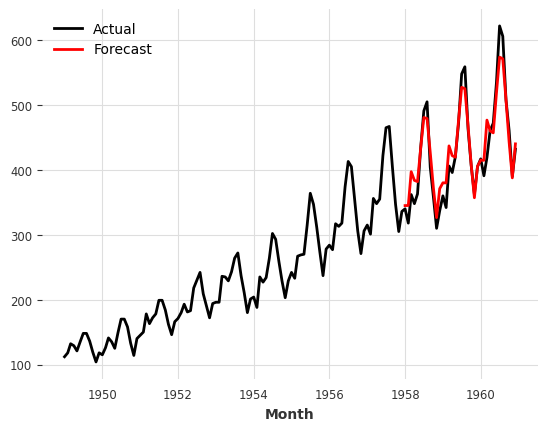

model Theta(theta=-3.5) obtains MAPE: 4.40%


In [ ]:
model = Theta(-3.5)
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast)
eval_forecast(model, val, forecast);


Бачимо, що слабше за SARIMAX.



## Прогнозування на основі Facebook Prophet

[**Facebook Prophet**](https://facebook.github.io/prophet/) був розроблений компанією Facebook і випущений у 2017 році. Інструмент був створений для того, щоб дати можливість людям без глибоких знань в статистиці створювати високоякісні прогнози часових рядів з урахуванням сезонності та інших факторів. Головна мета — забезпечити простий у використанні та налаштуванні інструмент, який автоматично визначає оптимальні параметри для створення точних прогнозів.

### Як це працює?
Facebook Prophet працює в три основні етапи. По-перше, фаза попередньої обробки полягає в очищенні та підготовці даних.

Інструмент автоматично обробляє відсутні значення, аномалії та викиди. Таким чином, користувачі можуть зосередитися на розумінні часових рядів, а не на виконанні цих завдань вручну.

Моделювання враховує тренд і сезонність для оцінки компонентів, пов'язаних з кожним періодом спостереження.

Сезонність може бути щоденним, щотижневим, щомісячним, річним або налаштованою відповідно до контексту. Після такої оцінки Prophet робить прогнози на бажаний майбутній період.


### Принцип роботи моделі

Facebook Prophet базується на адитивній моделі часових рядів, яка включає три основні компоненти:
1. **Тренд**: довгострокова тенденція зміни значень часових рядів.
2. **Сезонність**: періодичні зміни значень, які повторюються через регулярні інтервали часу.
3. **Святкові дні**: вплив специфічних дат на значення часових рядів.

Математична модель Prophet можна описати так:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

де:
- $ y(t) $ — значення часового ряду в момент часу $ t $.
- $ g(t) $ — функція тренду, яка моделює довгострокову зміну.
- $ s(t) $ — функція сезонності, що моделює періодичні зміни.
- $ h(t) $ — функція святкових днів, яка враховує специфічні дати.
- $ \epsilon_t $ — випадковий шум.

### Моделі тренду в Prophet

Prophet використовує дві основні моделі для моделювання тренду: piecewise linear та logistic growth. Кожна з них має свої параметри і формули.

#### 1. Piecewise Linear Model

**Piecewise linear model** моделює тренд як шматково-лінійну функцію, яка складається з кількох лінійних сегментів, що можуть змінюватися в точках згину.

Формула piecewise linear model:
$$ g(t) = (k + a(t)^T \delta) t + (m + a(t)^T \gamma) $$

де:
- $ k $ — початкова швидкість росту.
- $ a(t) $ — вектор показників, який вказує на наявність точок змінення (точок згину) у часі $ t $.
- $ \delta $ — вектор змін швидкості росту в точках згину.
- $ m $ — початкове значення (інтерсепт) тренду.
- $ \gamma $ — вектор змін інтерсепту в точках згину.

Пояснення параметрів:
- $k$: Початкова швидкість росту тренду. Визначає, як швидко змінюється тренд на початку періоду.
- $a(t)$: Вектор показників, який включає 0 або 1 для кожної точки часу $ t $, вказуючи на те, чи є ця точка часом зміни (точкою згину) тренду.
- **$\delta$**: Вектор, що вказує на зміну швидкості росту в кожній точці згину. Наприклад, якщо швидкість росту зростає на 0.1 в одній з точок згину, відповідний елемент $\delta$ буде 0.1.
- $m$: Початкове значення тренду (інтерсепт). Визначає початковий рівень тренду.
- $\gamma$: Вектор, що вказує на зміну інтерсепту в кожній точці згину. Ці зміни відображають зміни в рівні тренду в точках згину.

#### 2. Logistic Growth Model

**Logistic growth model** використовується для моделювання тренду з обмеженим ростом, де тренд асимптотично наближається до певної верхньої межі.

Формула logistic growth model:
$$ g(t) = \frac{C}{1 + \exp(-k(t - m))} $$

де:
- $ C $ — верхня межа росту (максимальна ємність).
- $ k $ — швидкість росту.
- $ m $ — параметр, що визначає точку згину (час, в який швидкість росту починає спадати).

Пояснення параметрів:
- **C**: Верхня межа росту. Визначає максимальне значення, до якого може наблизитися тренд.
- **k**: Швидкість росту. Визначає, як швидко тренд наближається до верхньої межі.
- **m**: Точка згину. Визначає час, в який тренд починає спадати, тобто коли швидкість росту починає знижуватися.

#### Чому саме такі формули?

1. **Piecewise Linear Model**:
   - Використовується для моделювання трендів, які можуть змінюватися в певні моменти часу, наприклад, у разі економічних криз, змін у політиці компанії, сезонних ефектів тощо.
   - Шматково-лінійний підхід дозволяє моделі підлаштовуватися під зміни в даних, зберігаючи простоту та інтерпретованість лінійних трендів.

2. **Logistic Growth Model**:
   - Використовується для моделювання насичених трендів, де зростання тренду сповільнюється і наближається до певної верхньої межі.
   - Логістична крива забезпечує реалістичне моделювання обмеженого росту, наприклад, насичення ринку продуктом, обмеження ресурсів тощо.
   - Параметри $ C $, $ k $ та $ m $ дозволяють гнучко налаштовувати модель для різних типів насичення і точок згину.

#### Сезонність

Для моделювання сезонності Prophet використовує чотиригармонійну модель Фур'є:

$$ s(t) = \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2 \pi n t}{P}\right) + b_n \sin\left(\frac{2 \pi n t}{P}\right) \right) $$

де:
- $ P $ — період сезонності (наприклад, 365.25 днів для річної сезонності).
- $ N $ — кількість гармонік, що використовуються для моделювання сезонності.

#### Святкові дні

Функція святкових днів $ h(t) $ враховує вплив специфічних дат на значення часового ряду. Для кожного свята визначається коефіцієнт впливу, і ці дати додаються до моделі.

#### Регресія та оптимізація

Prophet використовує байєсовий підхід для оцінки параметрів моделі, зокрема, метод Лапласового апроксимації для обчислення постерірі розподілів параметрів. Оптимізація виконується за допомогою градієнтних методів, таких як L-BFGS.

#### Переваги Facebook Prophet

1. **Автоматизація**: Prophet автоматично визначає оптимальні параметри для моделі, що робить його дуже простим у використанні навіть для людей без глибоких знань у статистиці.
2. **Підтримка сезонності та святкових днів**: модель враховує як річну, так і щотижневу сезонність, а також специфічні дати, які можуть впливати на значення часових рядів.
3. **Гнучкість**: можливість налаштування параметрів для більш точного прогнозу.
4. **Інтерпретація результатів**: результати прогнозу легко інтерпретуються завдяки розділенню на тренд, сезонність та вплив святкових днів.


**Приклад використання Prophet в Darts**:



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9f7lnw9/5m7q784i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9f7lnw9/il3nsbbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19523', 'data', 'file=/tmp/tmpf9f7lnw9/5m7q784i.json', 'init=/tmp/tmpf9f7lnw9/il3nsbbm.json', 'output', 'file=/tmp/tmpf9f7lnw9/prophet_model5z6tbhl2/prophet_model-20240805162700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


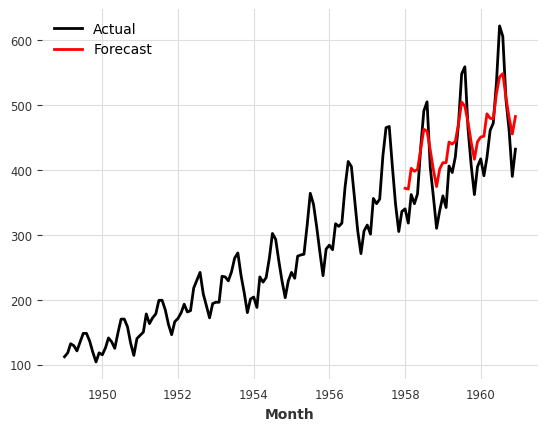

In [ ]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model, val, forecast);

model Prophet() obtains MAPE: 9.84%


На цих даних результат вийшов не дуже, але в цілому метод потужний і в них є окрема бібліотека: https://github.com/facebook/prophet



## Рекурентні нейронні мережі (RNN та LSTM)

RNN та LSTM - це типи нейронних мереж, що спеціалізуються на роботі з послідовними даними, такими як часові ряди. Концептуально тренуються ці моделі наступним  [чином](https://media.geeksforgeeks.org/wp-content/uploads/20231204125839/What-is-Recurrent-Neural-Network-660.webp) і відносяться до моделей глибокого навчання.

LSTM - покращена RNN, яка вміє запамʼятовувати довгі послідовності.

**Приклад використання LSTM в Darts**:



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

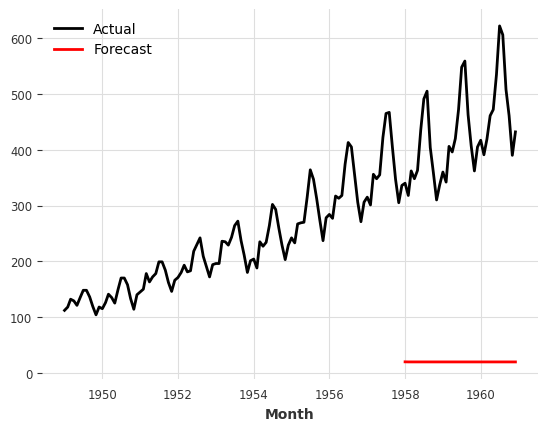

In [ ]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train)

# Прогнозування
forecast = model.predict(len(test))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

Якщо масштабувати дані і додати часових ознак:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

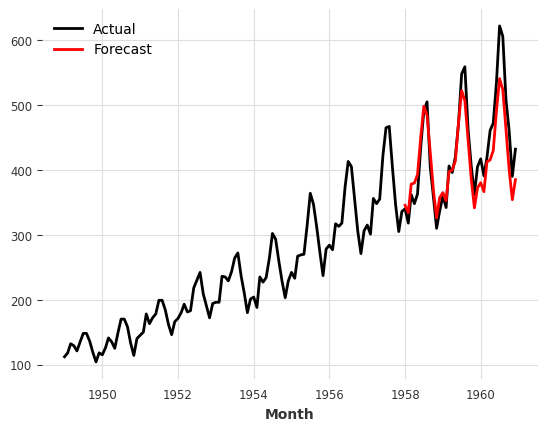

model RNNModel(model=LSTM, hidden_dim=20, training_length=20, input_chunk_length=14, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True) obtains MAPE: 5.98%


In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Масштабування даних
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# Створити серії з атрибутом року і місяця
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("1958-01-01"))

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True)

# Прогнозування
forecast = scaler.inverse_transform(model.predict(len(test)))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model, val, forecast);

Значно кращий результат!



## Трансформери та механізми attention

**Трансформери** - це архітектура нейронних мереж, яка використовує механізм self-attention для обробки послідовностей даних. Вперше запропоновані у статті "Attention Is All You Need" (Vaswani et al., 2017), трансформери стали основою багатьох сучасних моделей машинного навчання, особливо в області обробки природної мови (NLP) та аналізу часових рядів.

**Приклад використання трансформерів в Darts**:



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

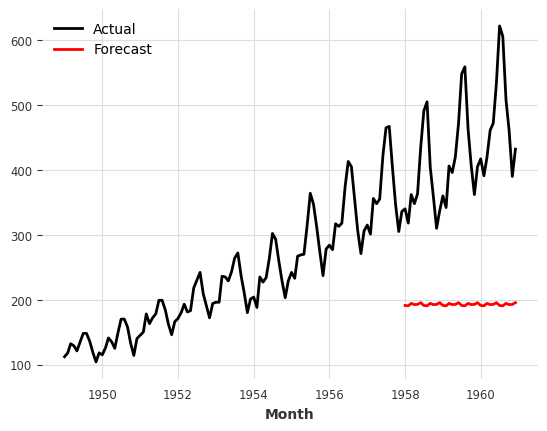

In [ ]:
from darts.models import TransformerModel

# Побудова та тренування моделі трансформера
model = TransformerModel(input_chunk_length=12, output_chunk_length=6, n_epochs=300)
model.fit(train)

# Прогнозування
forecast = model.predict(len(test))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

## Порівняння методів

Тож, коли які методи використовувати


| Метод          | Переваги                                      | Недоліки                                        | Використання                    |
|----------------|-----------------------------------------------|-------------------------------------------------|---------------------------------|
| ARIMA/SARIMA   | Простота інтерпретації, підходить для стаціонарних рядів | Обмежена робота з нестабільними рядами          | Економіка, фінанси              |
| Facebook Prophet | Простота налаштування, підтримка сезонності  | Менш точний для складних залежностей            | Бізнес-аналітика, маркетинг     |
| RNN/LSTM       | Потужність у моделюванні довгих залежностей   | Високі обчислювальні витрати                    | Розпізнавання мовлення, фінанси |
| Трансформери   | Висока точність, паралельна обробка           | Високі вимоги до ресурсів, складність налаштувань| Прогнозування продажів, аналіз тексту|
| XGBoost        | Гнучкість, висока точність, здатність обробляти складні залежності та великі обсяги даних | Вимоги до налаштувань параметрів, може бути складно інтерпретувати | Енергетика, фінансові ринки, прогнози погоди |


Вибір методу для аналізу часових рядів залежить від специфіки задачі, обсягу даних, доступних ресурсів та вимог до точності прогнозів. Класичні методи, такі як ARIMA/SARIMA, все ще залишаються корисними для багатьох задач, тоді як сучасні методи, такі як трансформери та RNN/LSTM, надають нові можливості для складних і великих наборів даних, де немає чітко вираженох сезонності і тренду особливо, де треба аби модель виявила фічі (це можуть моделі діплернінгу і не можуть класичні). XGBoost/LightGBM часто добре заходять на кагл змаганнях. Важливо експериментувати з різними методами, щоб знайти оптимальне рішення для конкретного випадку.

Дуже раджу переглянути [приклад](https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide) побудови моделі під інший тип часового ряду - який не має такої вираженої сезонності - будуть працювати інші методи краще. Тут ще time series analysis проводиться просто з pandas - доступно багато тих методів, що були розглянуті в лекції.


# Бектестинг: симуляція історичного прогнозування

Отже, на цьому етапі у нас є модель, яка добре працює на нашому валідаційному наборі, і це добре. Але як ми можемо дізнатися про продуктивність, яку ми *отримали б*, якби *використовували цю модель* на нових і нових даних?

**Бектестинг** симулює прогнози, які були б отримані з даною моделлю на нових даних в історії. Це може зайняти деякий час, оскільки модель (за замовчуванням) перенавчається кожного разу, коли симульований час прогнозу просувається вперед.

Візуалізація бектестингу:
![](https://miro.medium.com/v2/resize:fit:1400/0*E0xyoKfV9p5nOhTF.png)


Такі симульовані прогнози завжди визначаються відносно *горизонту прогнозування* (forecast horizon), який є кількістю часових кроків, на які ми будемо прогнозувати. У наведеному нижче прикладі ми будемо симулювати прогнози на 3 місяці вперед (порівняно з часом навчання).

Для бектесту можемо сокристатись методом моделі в `darts` `historical_forecasts()`. Цей метод дає обчислення історичних прогнозів за допомогою обраної моделі. Цей метод повторно формує навчальний набір: або розширюючи його з початку ряду `series`, або рухаючись із фіксованою довжиною `train_length`. Він навчає модель на навчальному наборі (можна обрати опцію і без постійного перенавчання, але частіше нам треба перенавчати), генерує прогноз довжиною, що дорівнює `forecast_horizon`, і потім переміщує кінець навчального набору вперед на `stride` кроків часу.

Важливі параметри:

- **series**:
  - Часовий ряд, використаний для послідовного навчання та обчислення історичних прогнозів.

- **forecast_horizon**:
  - Горизонт прогнозу для передбачень.

- **stride**:
  - Кількість кроків часу між двома послідовними прогнозами.

- **retrain**:
  - Вказує, чи потрібно і за яких умов перенавчати модель перед прогнозуванням.

- **last_points_only**:
  - Вказує, чи зберігати лише останню точку кожного історичного прогнозу.
  - Якщо встановлено `True`, метод повертає єдиний ``TimeSeries``, що містить послідовні точкові прогнози.
  - Інакше повертає весь список історичних прогнозів ``TimeSeries``.


In [ ]:
# наша найкраща модель

model = ARIMA(1, 1, 1, seasonal_order=(1, 1, 1, 12))
model.fit(train)
forecast = model.predict(len(val))
eval_forecast(model, val, forecast);

model ARIMA(p=1, q=1, seasonal_order=(1, 1, 1, 12)) obtains MAPE: 4.14%


 64%|██████▍   | 37/58 [00:34<01:02,  2.98s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 67%|██████▋   | 39/58 [00:46<01:24,  4.44s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 69%|██████▉   | 40/58 [00:52<01:29,  4.98s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 71%|███████   | 41/58 [01:04<01:57,  6.89s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 72%|███████▏  | 42/58 [01:10<01:46,  6.64s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood op

MAPE = 4.14%


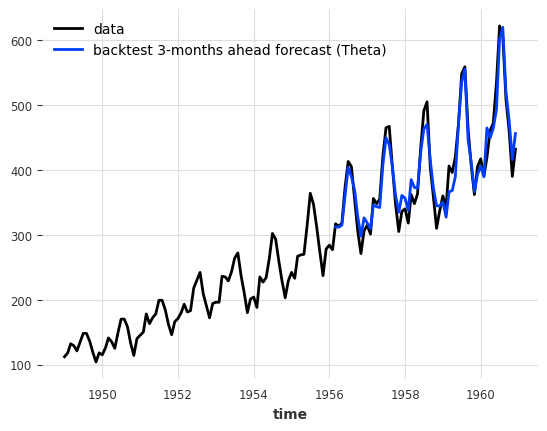

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("1956-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

Ми також можемо отримати всі передбачені значення з кожного історичного прогнозу, встановивши `last_points_only=False`. За допомогою параметра `stride` ми визначаємо, скільки кроків потрібно зробити між двома послідовними прогнозами. Ми встановлюємо його на 3 місяці, щоб потім можна було об'єднати прогнози в один `TimeSeries`.

 65%|██████▌   | 13/20 [00:37<00:23,  3.32s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 70%|███████   | 14/20 [00:45<00:29,  4.90s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 75%|███████▌  | 15/20 [00:52<00:27,  5.48s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 80%|████████  | 16/20 [01:00<00:25,  6.28s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


MAPE = 3.25%


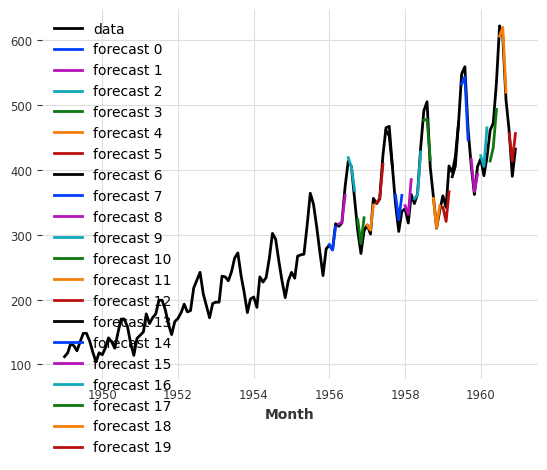

In [ ]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=3, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

Дуже хороший результати!

Щоб детальніше розглянути помилки, ми також можемо використати метод `backtest()`, щоб отримати всі сирі помилки (наприклад, помилки MAPE), які могла б отримати наша модель:

 64%|██████▍   | 37/58 [00:38<00:23,  1.12s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 67%|██████▋   | 39/58 [00:41<00:22,  1.17s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 69%|██████▉   | 40/58 [00:42<00:23,  1.31s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 71%|███████   | 41/58 [00:44<00:23,  1.38s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 72%|███████▏  | 42/58 [00:49<00:41,  2.61s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood op

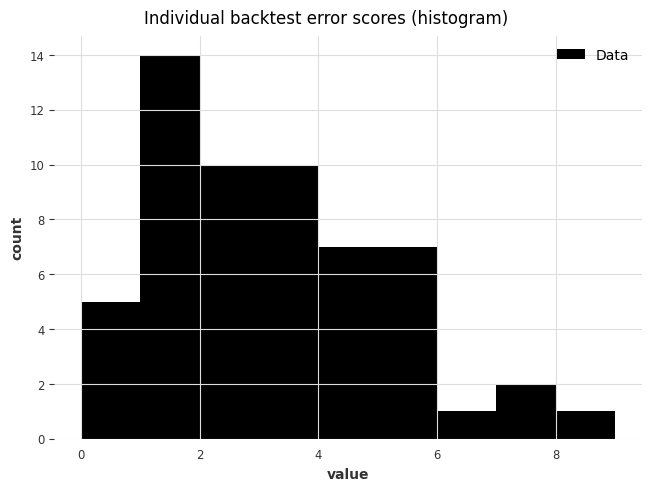

In [ ]:
raw_errors = model.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

Нарешті, використовуючи `backtest()`, ми також можемо отримати простіший вигляд середньої помилки за історичними прогнозами:

In [ ]:
average_error = model.backtest(
    metric=mape,
    reduction=np.mean,  # this is actually the default
    **hfc_params
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}")

 64%|██████▍   | 37/58 [00:29<00:17,  1.22it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 67%|██████▋   | 39/58 [00:33<00:30,  1.58s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 69%|██████▉   | 40/58 [00:36<00:37,  2.11s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 71%|███████   | 41/58 [00:38<00:34,  2.02s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 72%|███████▏  | 42/58 [00:40<00:31,  1.98s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood op

Average error (MAPE) over all historical forecasts: 3.30


Ми також могли б, наприклад, вказати аргумент `reduction=np.median`, щоб отримати медіанне MAPE.

Вище, `backtest()` повторно обчислював історичні прогнози кожного разу, коли ми його викликали. Ми також можемо використовувати деякі попередньо обчислені прогнози, щоб отримати результати набагато швидше!

In [ ]:
hfc_precomputed = model.historical_forecasts(last_points_only=False, stride=1, **hfc_params)
new_error = model.backtest(historical_forecasts=hfc_precomputed, last_points_only=False, stride=1, **hfc_params)

print(f"Average error (MAPE) over all historical forecasts: {new_error:.2f}")

 64%|██████▍   | 37/58 [00:35<00:20,  1.03it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 67%|██████▋   | 39/58 [00:38<00:22,  1.17s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 69%|██████▉   | 40/58 [00:45<00:55,  3.06s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 71%|███████   | 41/58 [00:47<00:44,  2.64s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 72%|███████▏  | 42/58 [00:51<00:46,  2.90s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood op

Average error (MAPE) over all historical forecasts: 3.30


### Огляд залишків
Давайте розглянемо залишки від прогнозованих значень нашої поточної моделі, тобто різницю між 1-кроковими прогнозами в кожний момент часу, отриманими шляхом підгонки моделі на всіх попередніх точках, і фактичними спостережуваними значеннями:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:



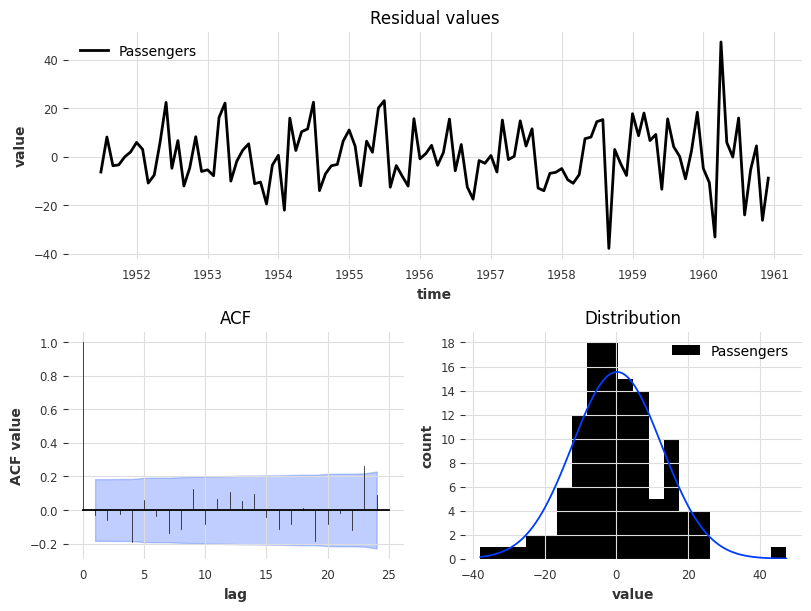

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model.residuals(series))

Ми можемо побачити, що розподіл центрований на 0, що означає, що наша модель не є упередженою.

Метод `residuals` насправді набагато потужніший! Його можна використовувати для обчислення будь-якої *метрики на кожному кроці часу* з Darts (дивіться список [тут](https://unit8co.github.io/darts/generated_api/darts.metrics.html)), навіть для багатокрокових прогнозів. Він також підтримує попередньо обчислені історичні прогнози, подібні до backtest.

Тепер давайте перевіримо розподіл абсолютних помилок, які ми отримуємо для кожного кроку в прогнозах на 3 місяці.

Text(0.5, 1.0, 'Absolute errors per forecast step')

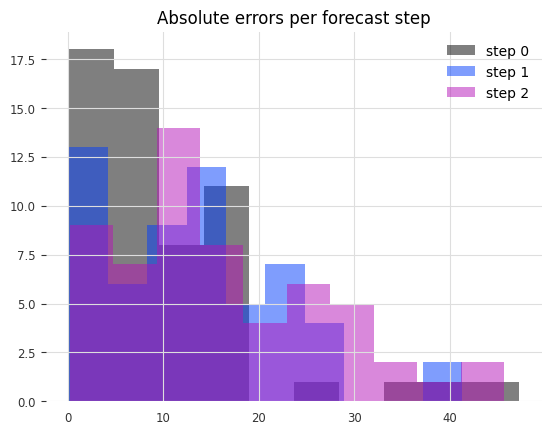

In [ ]:
from darts.metrics import ae
residuals = model.residuals(
    historical_forecasts=hfc_precomputed,
    metric=ae,  # the absolute error per time step
    last_points_only=False,
    values_only=True, # return a list of numpy arrays
    **hfc_params
)
residuals = np.concatenate(residuals, axis=1)[:, :, 0]

fig, ax = plt.subplots()
for forecast_step in range(len(residuals)):
    ax.hist(residuals[forecast_step], label=f"step {forecast_step}", alpha=0.5)
ax.legend()
ax.set_title("Absolute errors per forecast step")

Ми можемо чітко бачити, що помилки збільшуються, чим далі в майбутнє ми прогнозуємо.

### Порівняння з моделлю Theta
Можливо, ми могли б досягти кращих результатів бектесту за допомогою простої моделі `Theta`?

100%|██████████| 58/58 [00:01<00:00, 34.48it/s]


MAPE = 7.63%


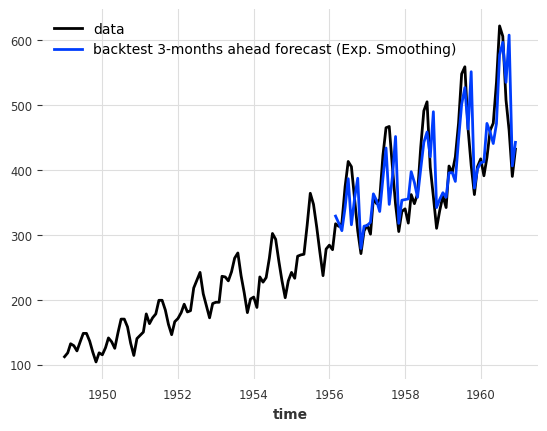

In [ ]:
model_theta = Theta(-3.5)
historical_fcast_theta = model_theta.historical_forecasts(**hfc_params)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print(f"MAPE = {mape(historical_fcast_theta, series):.2f}%")

Модель працює явно гірше, але значно швидше!

100%|██████████| 141/141 [00:03<00:00, 36.41it/s]


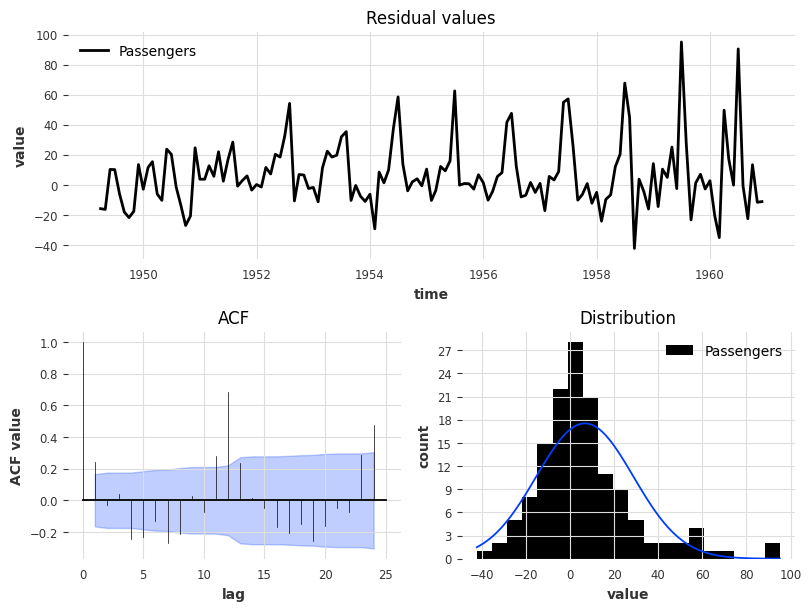

In [ ]:
plot_residuals_analysis(model_theta.residuals(series, verbose=True))

Ми можемо побачити, що розподіл не центрований на 0, що означає, що наша модель `Theta` є упередженою. Ми також можемо помітити велике значення ACF (автокореляційної функції) при лагу, рівному 12, що вказує на те, що залишки містять інформацію, яка не була використана моделлю.

Тож, ця модель - гірша і ми це бачимо з аналізу залишків.



# Додаткові ресурси на розширення знань

- Більше про те, які ще є моделі прогнозування в Darts, можна знайти [тут](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html )
- Приклади використання різних моделей знайдете [тут](https://unit8co.github.io/darts/examples/20-RegressionModel-examples.html)
- Також раджу ознаймотитись з Anomaly detection в Darts - гайд по цій темі знайдете [тут](https://unit8co.github.io/darts/examples/22-anomaly-detection-examples.html)
- Приклад розвʼязку складної задачі, коли є не один часовий ряд, а кілька [тут](https://www.kaggle.com/code/ferdinandberr/darts-forecasting-deep-learning-global-models)